In [1]:
%run ../scripts/notebook_settings_lean.py
from scipy import stats
from horizonplot import horizonplot
from chromwindow import window
from ete3 import Tree


# UPGMA

In [2]:
def find_lowest_cell(table):
    x = 1
    y = 0
    min_val = table[x][y]
    for i in range(len(table)):
        for j in range(len(table[i])):
            if table[i][j] < min_val:
                min_val = table[i][j]
                x = i
                y = j
    return [x, y]

def link(x, y, wx, wy):
    return (x * wx + y * wy) / (wx + wy)

def update_table(table, a, b, weight_a, weight_b):
    for i in range(0, b):
        table[b][i] = link(table[b][i], table[a][i], weight_b, weight_a)
    for j in range(b+1, a):
        table[j][b] = link(table[j][b], table[a][j], weight_b, weight_a)
    for i in range(a+1, len(table)):
        table[i][b] = link(table[i][b], table[i][a], weight_b, weight_a)
    for i in range(a+1, len(table)):
        del table[i][a]
    del table[a] 

def update_labels(labels, i, j, di, dj):
    labels[j] = "({}:{},{}:{})".format(labels[j], dj, labels[i], di)
    del labels[i]

def upgma(mat, names):

    table = mat[:]
    labels = names[:]
    node_heights = [0 for _ in labels]

    while len(labels) > 1:
        i, j = find_lowest_cell(table)
        
        dist = table[i][j]

        wi = max(1, labels[i].count(':'))
        wj = max(1, labels[j].count(':'))

        new_node_height = dist / 2
        di = new_node_height - node_heights[i]
        dj = new_node_height - node_heights[j]
        
        update_table(table, i, j, wi, wj)
        update_labels(labels, i, j, di, dj)
        node_heights[j] = new_node_height
        del node_heights[i]
        
    return labels[0] + ';'

## Distance matrix

In [3]:
def jc(seq1, seq2, case_sensitive=True):
    assert len(seq1) == len(seq2), (len(seq1), len(seq2))
    tot, diff = 0, 0
    for x, y in zip(seq1, seq2):
        if not case_sensitive:
            x, y = x.upper(), y.upper()
        if x in 'ATCG' and y in 'ATCG':
            if x != y:
                diff += 1
            tot += 1    
    if not tot:
        return np.nan
    elif diff:
        distance = -3/4 * math.log(1 - 4/3 * diff/tot)
    else:
        distance = 0.0
    return distance


def dist_matrix(seq_list, case_sensitive=True, dist_fun=jc):
    n = len(seq_list)
    mat = np.zeros((n, n))

    upper_trag_idx = list(zip(*np.triu_indices(n, k=1)))
#     seq_pairs = [(seq_list[i], seq_list[j]) for i, j in upper_trag_idx]
    args = [(seq_list[i], seq_list[j], case_sensitive) for i, j in upper_trag_idx]

    jc_distances = []
    for a, b, c in args:
        jc_distances.append(dist_fun(a, b, c))
    
    # with Pool(int(os.environ['SLURM_CPUS_PER_TASK'])) as p:
    #     jc_distances = p.starmap(dist_fun, args)

    for (i, j), d in zip(upper_trag_idx, jc_distances):
        mat[i][j] = d
        mat[j][i] = mat[i][j]

    return mat


def prune_nans(mat, name_list):

    # Find rows (and cols) where all off-diagonal entries are nan:
    mask = np.isnan(mat).sum(axis=0) == np.size(mat, axis=0)-1
    delete = [i for (i, delete) in enumerate(mask) if delete]
    # remove those rows and cols:
    mat = np.delete(mat, delete, axis=0)
    mat = np.delete(mat, delete, axis=1)
    # update name list:
    name_list = [name for (i, name) in enumerate(name_list) if i not in delete]
    
    # if there are any nans left we have to remove all row/cols with a nan:
    if np.isnan(mat).any():    
        # in that case we could do this to remove all row/cols with a nan
        mask = np.isnan(mat).sum(axis=0).astype('bool')
        delete = [i for (i, delete) in enumerate(mask) if delete]
        # remove those rows and cols:
        mat = np.delete(mat, delete, axis=0)
        mat = np.delete(mat, delete, axis=1)
        # update name list:
        name_list = [name for (i, name) in enumerate(name_list) if i not in delete]
        
    return mat, name_list

## Construct and manipulate tree

In [4]:
def tree_newick(name_list, seq_list, case_sensitive=True, dist_fun=jc):

    mat = dist_matrix(seq_list, case_sensitive=case_sensitive, dist_fun=dist_fun)
    mat, name_list = prune_nans(mat, name_list)
    
    lowtri = [lst[:i] for (i, lst) in enumerate(mat.tolist())]
    newick_str = upgma(lowtri, name_list)
    return newick_str

def order_tree(t, key=lambda c: len(c.get_leaves())):
    """
    without key for sorting it makes a comb tree by default
    """
    for node in t.traverse():
        if not node.is_leaf():
            node.children = sorted(node.children, key=key, reverse=False)

def remove_outgroup(name):
    tree.set_outgroup( tree&name )
    all_leaves = tree.get_leaf_names()
    all_leaves.remove(name)
    tree.prune(all_leaves, preserve_branch_length=False)


# # remove chimp outgroup branches
# tree.set_outgroup( tree&"Outgroup" )
# all_leaves = tree.get_leaf_names()
# all_leaves.remove('Outgroup')
# tree.prune(all_leaves, preserve_branch_length=False)

In [5]:
def plot_tree(t, ax, leaf_colors=None, show_inner_nodes=False, fontsize=10, 
              text_offset=None, margins=(0.5, 1, 0.5, 1)): # top, right, bottom, left

    y_offset = len(t.get_leaves())
    for node in t.traverse("preorder"):
        node.x_offset = node.dist + sum(x.dist for x in node.get_ancestors())
        if node.is_leaf():
            y_offset -= 1
            node.y_offset = y_offset

    for node in t.traverse("postorder"):
        if not node.is_leaf():
            node.y_offset = sum(x.y_offset for x in node.children) / len(node.children)

    horizontal_lines = list()
    vertical_lines = list()
    node_coords = list()
    leaf_coords = list()
    max_x_offset = 0
    for node in t.traverse("postorder"):
        max_x_offset = max(max_x_offset, node.x_offset)
        node_coords.append((node.x_offset, node.y_offset))
        if node.is_leaf():
            leaf_coords.append([node.name, node.x_offset, node.y_offset])
        if not node.is_root():
            y = node.y_offset
            horizontal_lines.append(([node.up.x_offset, node.x_offset], [y, y]))
        if not node.is_leaf():
            c = sorted(node.children, key=lambda x: x.y_offset)
            bottom, top = c[0], c[-1]
            x = node.x_offset
            vertical_lines.append(([x, x],[bottom.y_offset, top.y_offset]))

    
    # shift the tree to put leaves at zero
    for i in range(len(horizontal_lines)):
        horizontal_lines[i][0][0] -= max_x_offset
        horizontal_lines[i][0][1] -= max_x_offset
    for i in range(len(vertical_lines)):
        vertical_lines[i][0][0] -= max_x_offset
        vertical_lines[i][0][1] -= max_x_offset
    for i in range(len(leaf_coords)):
        leaf_coords[i][1] -= max_x_offset
            
    # draw the tree:
    for x in horizontal_lines:
        ax.plot(*x, c='black', linewidth=0.8)
    for x in vertical_lines:
        ax.plot(*x, c='black', linewidth=0.8)

#     for tup in node_coords:
#         ax.plot(*tup, c='black', marker="o")

    if text_offset is None:
        text_offset = max_x_offset / 20
        
    for name, x, y in leaf_coords:
        ax.text(x+text_offset, y, name, fontsize=fontsize,
                verticalalignment='center', horizontalalignment='left')
        if leaf_colors is None:
            color = 'black'
        else:
            color = leaf_colors[name]
        ax.plot(x, y, c=color, marker="o", ms=3)


#     ax.set_xlim(-margins[3], max_x_offset + margins[1])
    ax.set_xlim(-margins[3]-max_x_offset, margins[1])
    ax.set_ylim(-margins[2], len(leaf_coords)-1+margins[0])


    #ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False) 
    ax.spines['right'].set_visible(False)
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
    return leaf_coords

In [6]:
def proportion_same_ancestry(*args):
    a, b, case_sensitive = args
    "a and b are arrays or seris of posterior probabilities of minor parent ancestry"
    return np.absolute(a.round() - b.round()).sum()

def order_fun(c):
    leaf_names = [x.name for x in c.get_leaves()]
    idx = [sample_name_list.index(x) for x in leaf_names]
    return seq_window_list[idx].mean()

In [7]:
def create_paint_df_ind_compressed(df, ind, mapping, ns_map):
    d = {}
    max_pos = int(df.epos.iloc[-1])
    df = df.loc[df[ind].shift() != df[ind]].reset_index()
    df["epos"] = pd.concat([df.spos.iloc[1:], pd.Series(max_pos)], ignore_index=True)
    d["pos"] = df.spos
    d["end_pos"] = df.epos -1
    d["length"] = df.epos - df.spos
    d["reference"] = df[ind].map(mapping)
    d["n/s"] = d["reference"].map(ns_map)
    d["individual"] = ind[:-2]
    d["haplotype"] = ind[-1:]
    return pd.DataFrame(d)

meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/tanzania_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Kindae, Zambia': 0,
 'Papio, Senegal': 1,
 'Ursinus, Zambia': 0}

df_l = []
for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind_compressed(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)
df_l = []
for c in ["chr{}".format(x) for x in (range(1, 21))] + ["chrX"]:
    genetic_map = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/mikumi_pyrho_genetic_map_{}.txt"
    chr_recomb = pd.read_csv(genetic_map.format(c), sep=" ")
    df_l.append(chr_recomb)
recomb_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [8]:
length_df["haplo_ID"] = length_df.individual +"_"+ length_df.haplotype
length_df["start"] = length_df.pos
length_df["north"] = length_df["n/s"]*2-1
length_df["total_north"] = length_df["north"]*length_df.length

In [9]:
male_IDs = meta_data_samples.loc[meta_data_samples.Sex == "M"].PGDP_ID

Removing hap2 for males, and setting up filters for the various sub-populations.

In [10]:
tanzania = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Central Tanzania",
                                                                "Anubis, Tanzania",
                                                                "Cynocephalus, Western Tanzania"])].PGDP_ID
olive = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Anubis, Tanzania"])].PGDP_ID
eth = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Anubis, Ethiopia"])].PGDP_ID
yellow = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Central Tanzania",
                                                                "Cynocephalus, Western Tanzania"])].PGDP_ID
western = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Western Tanzania"])].PGDP_ID
ruaha = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID
df_tanz = length_df.loc[length_df.individual.isin(tanzania)]

df = length_df.loc[length_df.chrom == "all_chrX"]
df = df.loc[~(df.individual.isin(male_IDs) & (df.haplotype == "1"))]

Adding a filter for callabiity

In [11]:
c_r_g_df = pd.read_csv("../steps/rfmix_stats_df/call_recomb_genes.txt")

In [12]:
df_l = []
for c in df.chrom.unique():
    print(c)
    l_df = df.loc[df.chrom == c].copy()
    if c == "female_chrX" or c == "all_chrX":
        c = "chrX"
    r_df = recomb_df.loc[(recomb_df.chromosome == c)]
    pos_mapping = dict(zip(r_df.position, r_df["Genetic_Map(cM)"]))
    l_df["start_cM"] = l_df.pos.map(pos_mapping)
    l_df["end"] = l_df.end_pos + 1
    l_df["end_cM"] = l_df.end.map(pos_mapping)
    call_df = c_r_g_df.loc[c_r_g_df.chrom == c]
    df_call_filt = []
    df_l.append(l_df)
df = pd.concat(df_l)
callable_df = call_df.loc[call_df.callable_frac > 0.75].reset_index()
c_s = callable_df.iloc[0].start
c_e, old_end = callable_df.iloc[0].start, 0
# Seems weird, but how makes it work correctly for identifying intervals in filters
r_s = callable_df.iloc[0].cM
sub_df_l, gap_df_l = [], []
for i, row in callable_df.iterrows():
    if c_e != row.start:# or i+1 == len(callable_df):
        sub_df = df.loc[(df.end_pos > c_s) & (df.pos < c_e)]
        sub_df.loc[sub_df.start_cM < r_s, "start_cM"] = r_s
        sub_df.loc[sub_df.end_cM > row.end_cM, "end_cM"] = row.end_cM
        sub_df.loc[sub_df.pos < c_s, "pos"] = c_s
        sub_df.loc[sub_df.end_pos > c_e, "end_pos"] = c_e
        sub_df_l.append(sub_df)
        # Add start/ends
        start_df = sub_df.loc[sub_df.pos == c_s].copy()
        start_df.end_pos, start_df.end_cM, start_df.north = c_s, r_s, 0
        end_df = sub_df.loc[sub_df.end_pos == c_e].copy()
        end_df.pos, end_df.cM, end_df.north = c_e, r_s, 0
        gap_df_l.append(start_df), gap_df_l.append(end_df)
        # update df_l with new slice of fragment_df
        c_s, c_e, r_s = row.start, row.end, row.cM
    else:
        c_e = row.end
df_filt = pd.concat(sub_df_l)
gap_df = pd.concat(gap_df_l)

all_chrX


In [13]:
df_f = pd.concat([df_filt, gap_df])
df_f['pop'] = df_f.haplo_ID
df_f['is_north'] = (df_f.north == 1).astype(int)
df_f['is_south'] = (df_f.north == -1).astype(int)
df_f['is_filtered'] = (df_f.north == 0).astype(int)
df_f = df_f.sort_values(['pop', 'chrom', 'pos', 'is_north', 'is_south'])

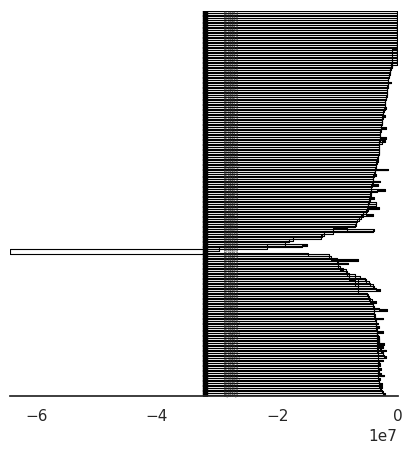

In [14]:
df['pop'] = df.haplo_ID
df['is_north'] = (df.north == 1).astype(int)
df['is_south'] = (df.north == -1).astype(int)
df['is_filtered'] = (df.north == 0).astype(int)
df = df.sort_values(['pop', 'chrom', 'pos'])

haplo_ID_list = list(df.haplo_ID.unique())

north_south_segment_lists = []
for sample_name in haplo_ID_list:
    north_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 1), ['pos', 'end_pos']].itertuples(index=False, name=None))
    south_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 0), ['pos', 'end_pos']].itertuples(index=False, name=None))
    north_south_segment_lists.append((north_tuples, south_tuples))

def tot_overlap(arr1, arr2):
    """total overlap of two lists of intervals"""
    tot = 0
    i = j = 0
    n = len(arr1)
    m = len(arr2)
    while i < n and j < m:
        l = max(arr1[i][0], arr2[j][0])
        r = min(arr1[i][1], arr2[j][1])
        if l <= r: 
            tot += r - l
        if arr1[i][1] < arr2[j][1]:
            i += 1
        else:
            j += 1
    return tot

def proportion_same_ancestry(*args):
    """proportion of chromsome with same ancestry"""
    a, b, case_sensitive = args
    ovl = tot_overlap(a[0], b[0]) + tot_overlap(a[1], b[1])
    return 77000000 - ovl
    
newick_str = tree_newick(haplo_ID_list, north_south_segment_lists, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

def order_fun(c):
    """order child clades so that leaves in left has more north ancestry"""
    leaf_names = [x.name for x in c.get_leaves()]
    idx = [haplo_ID_list.index(x) for x in leaf_names]
    return sum(e-s for i in idx for (s, e) in north_south_segment_lists[i][1]) - sum(e-s for i in idx for (s, e) in north_south_segment_lists[i][0])

order_tree(tree, key=order_fun)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

leaf_info = plot_tree(tree, ax1, fontsize=2)
haplo_ID_sorting, x, y = zip(*leaf_info)

In [15]:
# Colors old - sticking with it
hamadryas_north = '#91a89e'
olive_north = '#495F43'
yellow_south = '#FFF6B4'

# Colors new
hamadryas_north = '#80a695'
olive_north = '#495F43'
yellow_south = '#d6c965'

# Colors new2
hamadryas_north = '#80a695'
olive_north = '#495F43'
yellow_south = '#a69680'


/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made lar

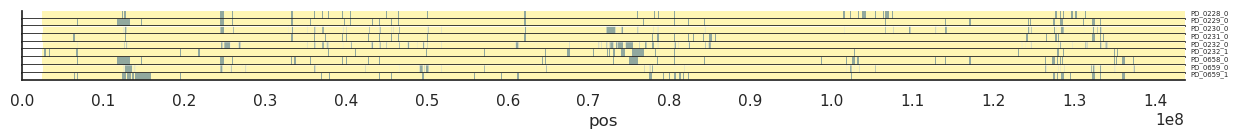

In [16]:
def stairs(df, start='pos', end='end_pos', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])
df["Origin"] = df.individual.map(dict(zip(meta_data_samples.PGDP_ID, meta_data_samples.Origin)))
input_df = df.loc[df.Origin.isin(['Mahale, Tanzania'])]

plot_df = stairs(input_df).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.1, aspect=150,
                    row_order=plot_df.haplo_ID.unique(), margin_titles=True, gridspec_kws={'hspace':0.0})

g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=yellow_south,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_filtered', 
    y2=0,
    color="#ffffff",
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(plot_df.haplo_ID.unique(), g.axes.flat):
    ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(plot_df.pos)+1, 10000000))

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

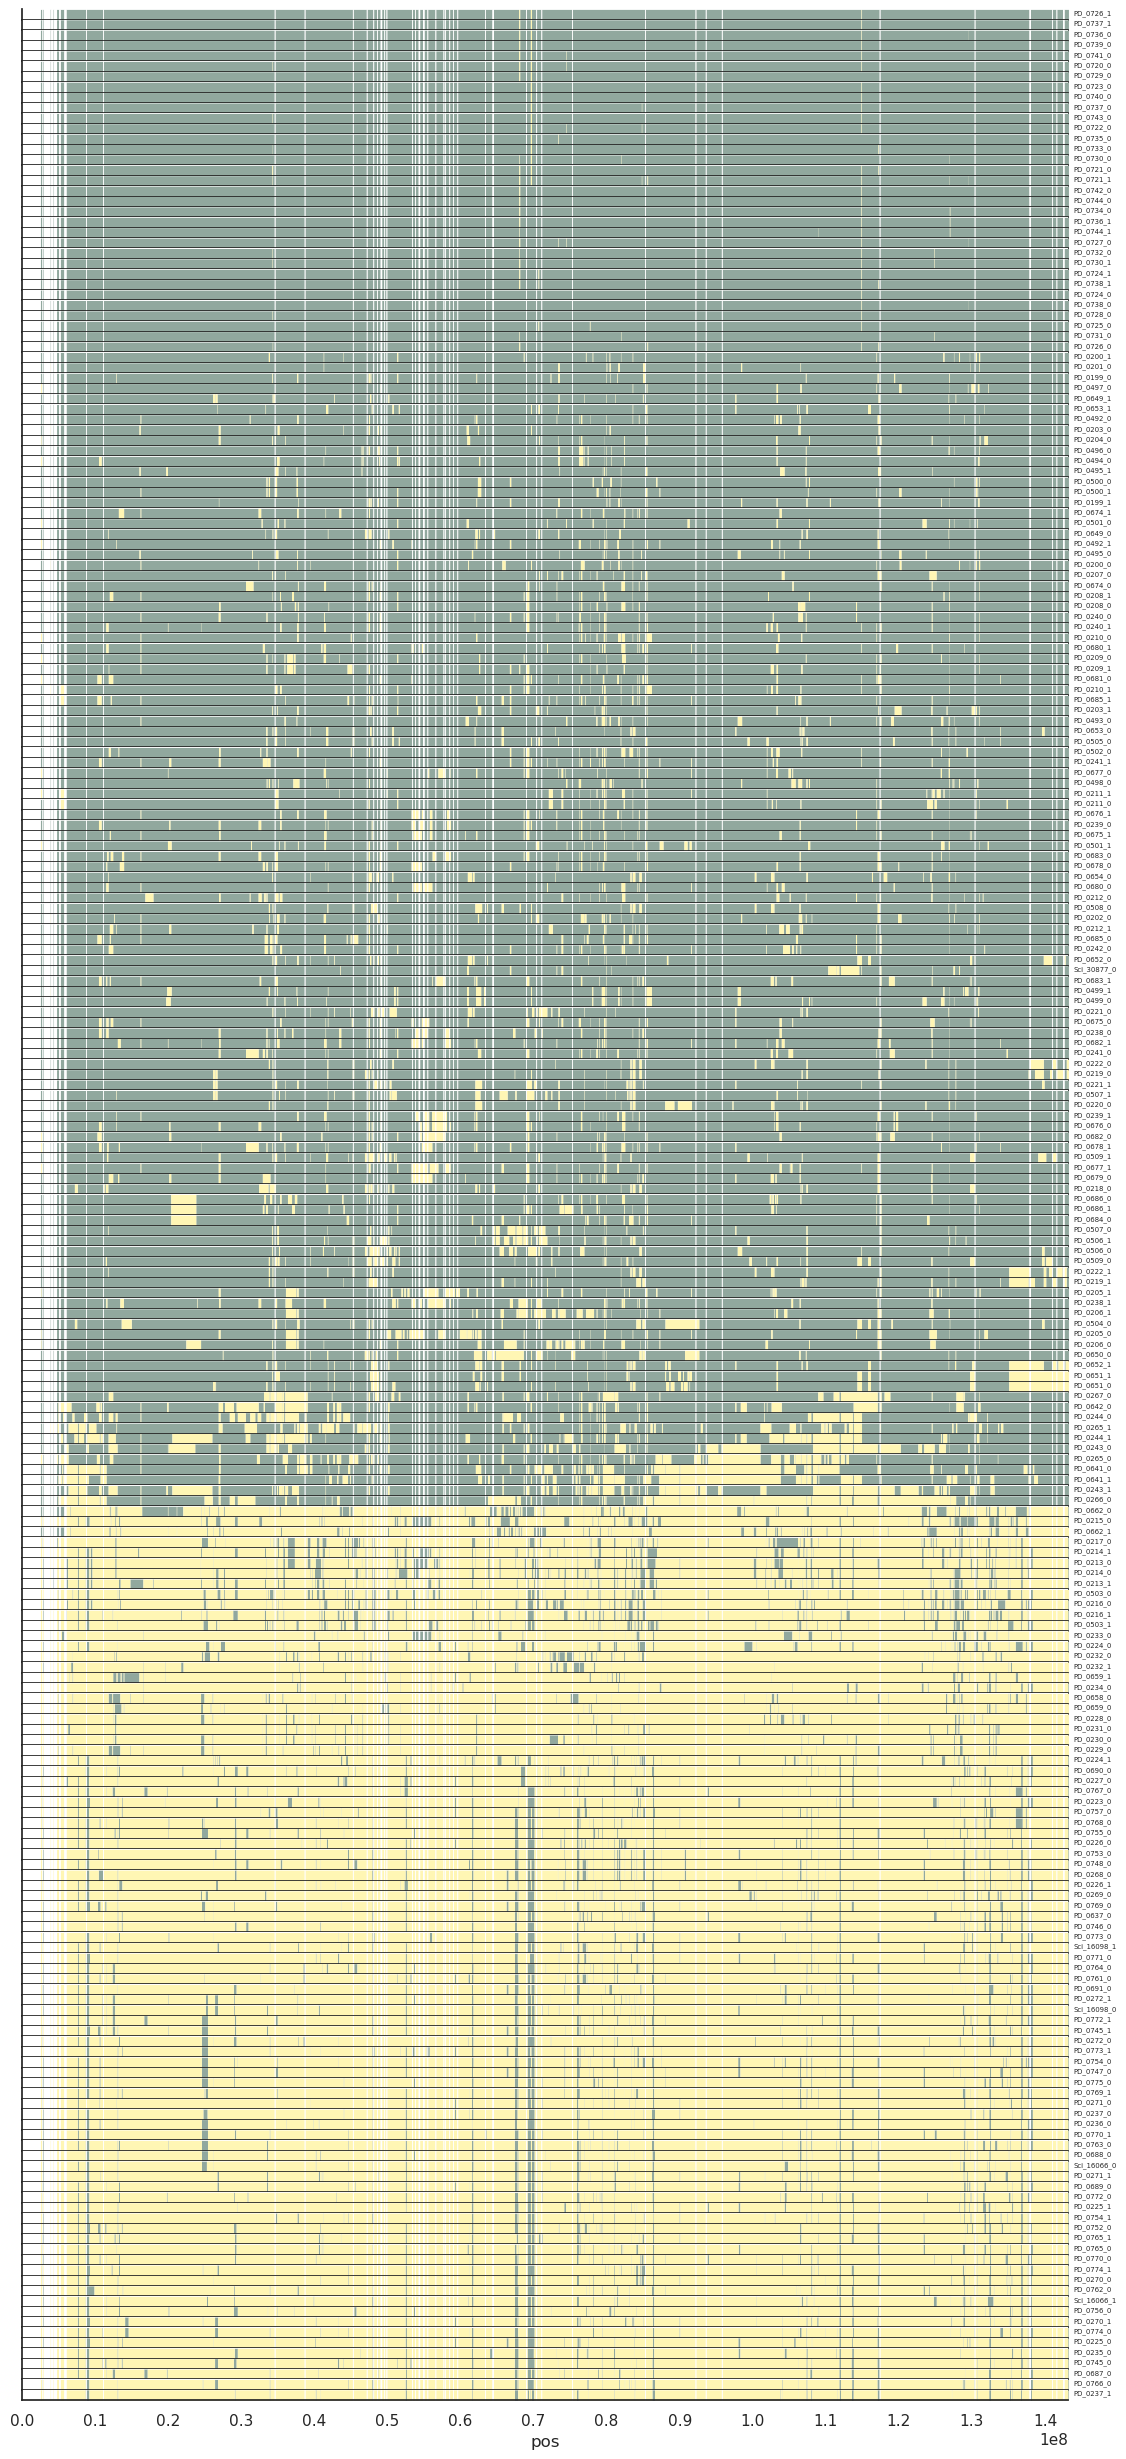

In [17]:
def stairs(df, start='pos', end='end_pos', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

plot_df = stairs(df_f).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.135, aspect=100,
                    row_order=haplo_ID_sorting, margin_titles=True, gridspec_kws={'hspace':0.0})
# Non-large version is made with height = 0.1 and aspect 150.
g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=yellow_south,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_filtered', 
    y2=0,
    color="#ffffff",
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(haplo_ID_sorting, g.axes.flat):
    ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
g.savefig("../figures/all_chrX_tanzfocus_filt075_large.pdf")

In [96]:
result_order = ['Selous, Tanzania', 'Mikumi, Tanzania', 'Udzungwa, Tanzania', 'Ruaha, Tanzania',
       'Tarangire, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania', 
             'Lake Manyara, Tanzania', 'Serengeti, Tanzania', 'Gog Woreda, Gambella region, Ethiopia']
df_f["Origin"] = df_f.individual.map(dict(zip(meta_data_samples.PGDP_ID, meta_data_samples.Origin)))
#df_sorted = stairs(df_f).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
df_sorted = df_f.sort_values(by=["Origin"], key=lambda x: x.map({v: i for i, v in enumerate(result_order)}), ascending=False)
df_sorted = df_sorted.loc[df_sorted.Origin.isin(result_order)]

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made lar

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

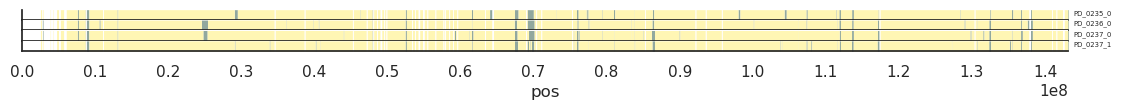

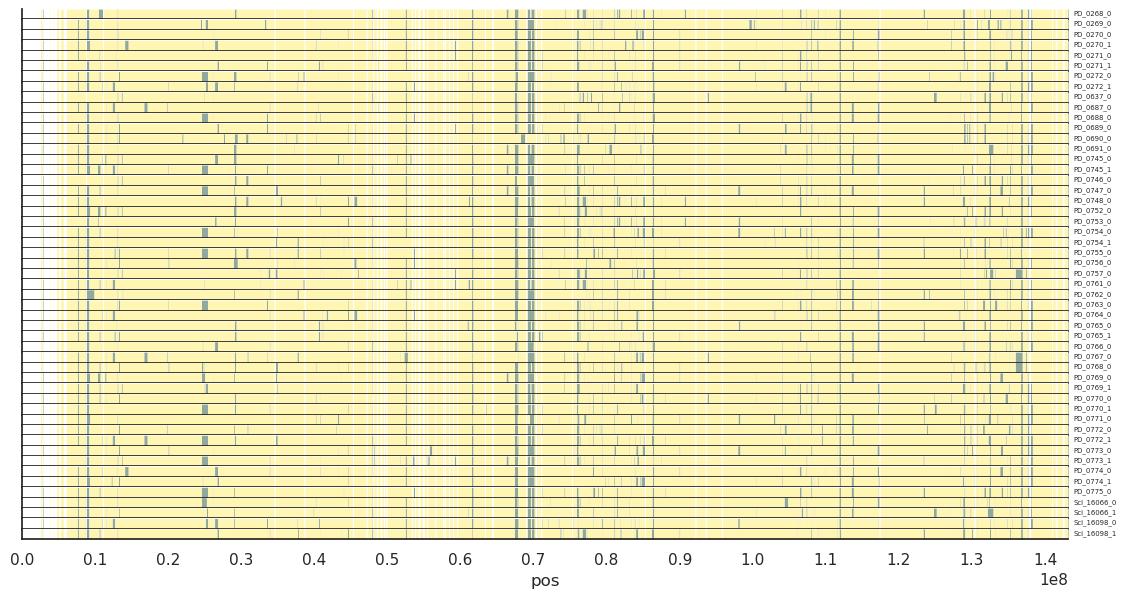

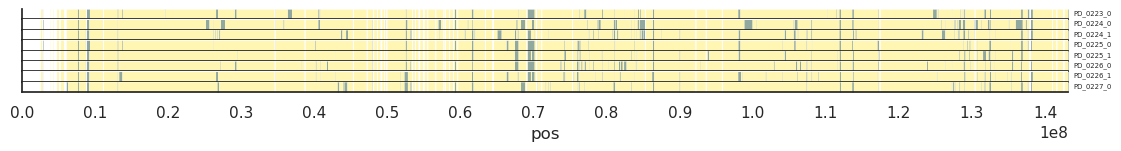

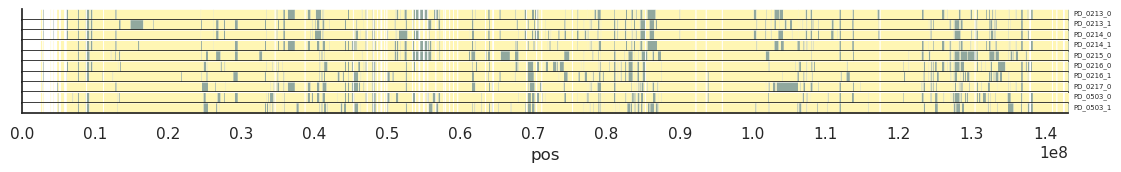

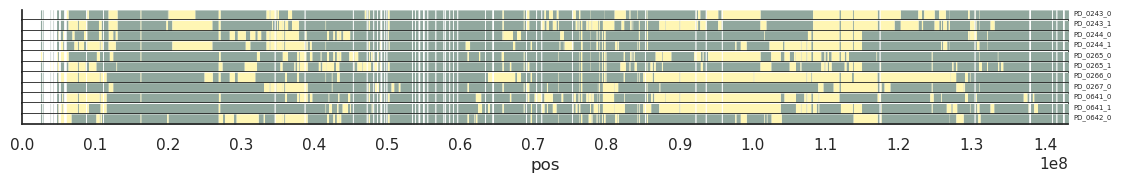

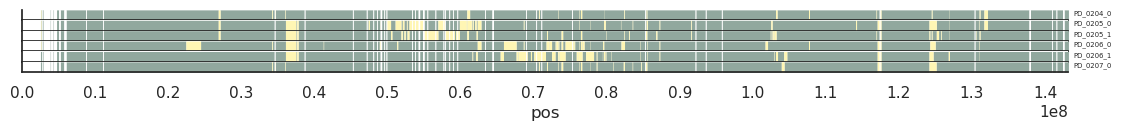

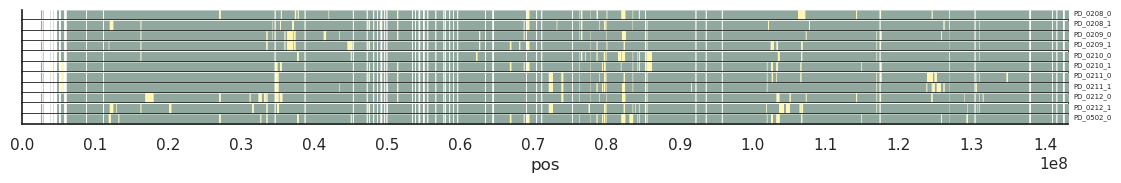

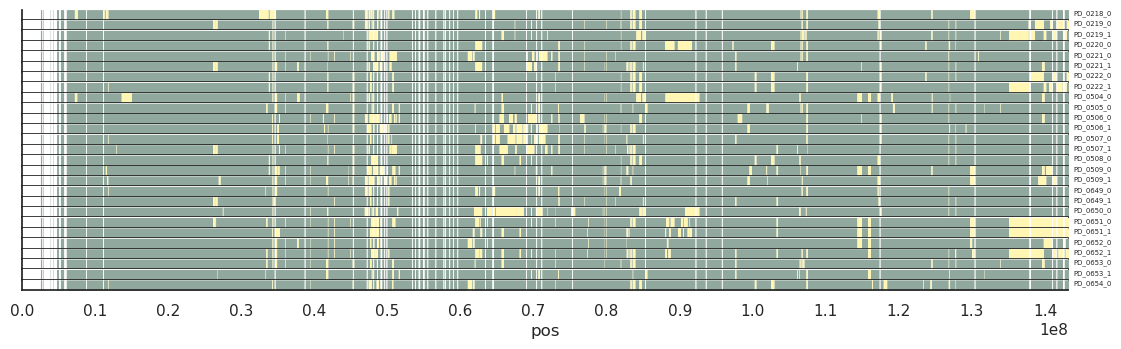

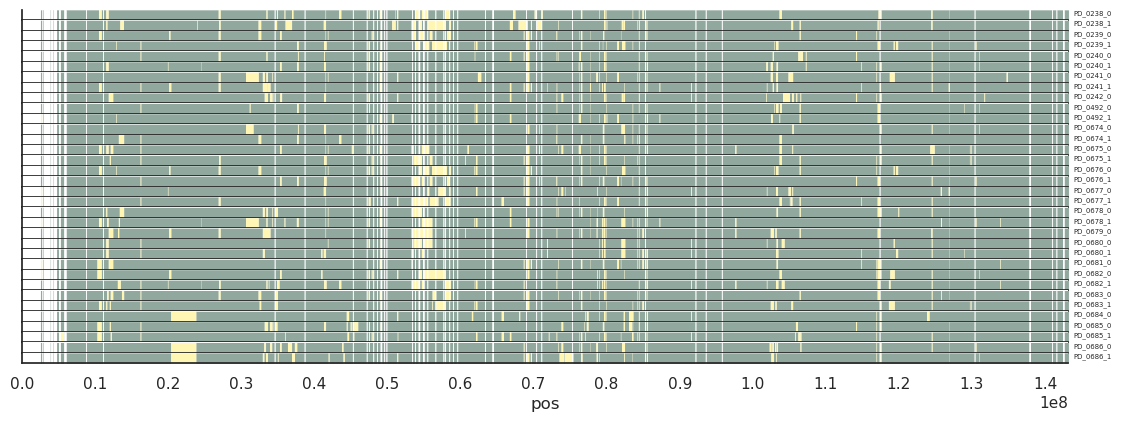

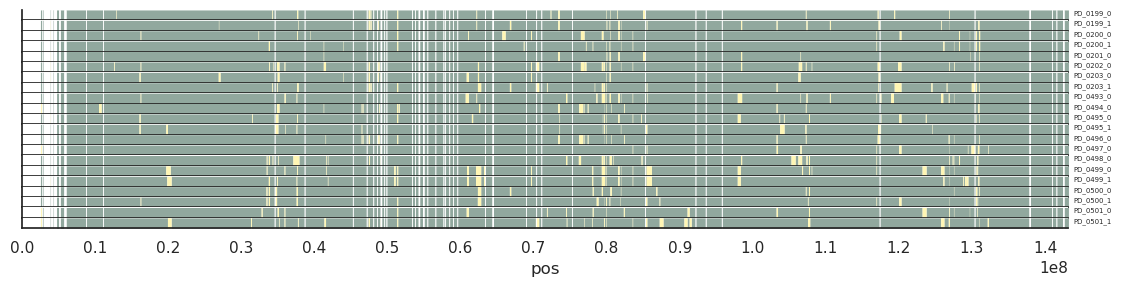

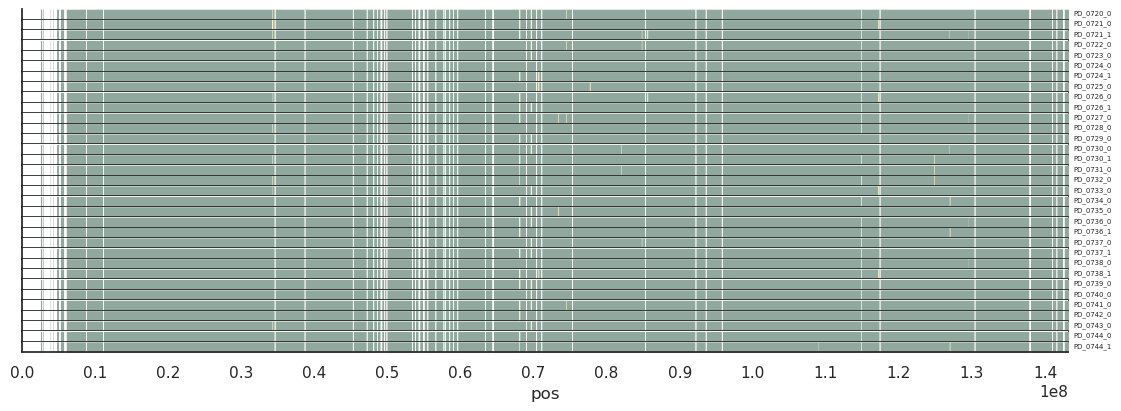

In [100]:

for o in result_order: 
    plot_df = stairs(df_f.loc[df_f.Origin == o]).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
    g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.135, aspect=100,
                    row_order=plot_df.haplo_ID.unique(), margin_titles=True, gridspec_kws={'hspace':0.0})
    # Non-large version is made with height = 0.1 and aspect 150.
    g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
    g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=yellow_south,
    linewidth=0,
    capstyle='butt')
    g.map(plt.fill_between, 
    'pos', 
    'is_filtered', 
    y2=0,
    color="#ffffff",
    linewidth=0,
    capstyle='butt')
    g.set_titles(col_template="", row_template="")
    g.set(yticklabels=[])  
    g.set(ylabel=None)
    g.tick_params(left=False)  # remove the ticks 
    for label, ax in zip(plot_df.haplo_ID.unique(), g.axes.flat):
        ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
        ax.set_ylim(0, 1)    
        ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
        ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
        g.savefig("../figures/all_chrX_{}_filt075_large.pdf".format(o))

Chr1 block buster workflow

In [17]:
df = length_df.loc[length_df.chrom == "chr1"]
df_l = []
for c in df.chrom.unique():
    print(c)
    l_df = df.loc[df.chrom == c].copy()
    if c == "female_chrX" or c == "all_chrX":
        c = "chrX"
        l_df = l_df.loc[~(l_df.individual.isin(male_IDs) & (l_df.haplotype == "1"))]
    r_df = recomb_df.loc[(recomb_df.chromosome == c)]
    pos_mapping = dict(zip(r_df.position, r_df["Genetic_Map(cM)"]))
    l_df["start_cM"] = l_df.pos.map(pos_mapping)
    l_df["end"] = l_df.end_pos + 1
    l_df["end_cM"] = l_df.end.map(pos_mapping)
    call_df = c_r_g_df.loc[c_r_g_df.chrom == c]
    df_call_filt = []
    df_l.append(l_df)
df = pd.concat(df_l)
callable_df = call_df.loc[call_df.callable_frac > 0.75].reset_index()
c_s = callable_df.iloc[0].start
c_e, old_end = callable_df.iloc[0].start, 0
# Seems weird, but how makes it work correctly for identifying intervals in filters
r_s = callable_df.iloc[0].cM
sub_df_l, gap_df_l = [], []
for i, row in callable_df.iterrows():
    if c_e != row.start:# or i+1 == len(callable_df):
        sub_df = df.loc[(df.end_pos > c_s) & (df.pos < c_e)]
        sub_df.loc[sub_df.start_cM < r_s, "start_cM"] = r_s
        sub_df.loc[sub_df.end_cM > row.end_cM, "end_cM"] = row.end_cM
        sub_df.loc[sub_df.pos < c_s, "pos"] = c_s
        sub_df.loc[sub_df.end_pos > c_e, "end_pos"] = c_e
        sub_df_l.append(sub_df)
        # Add start/ends
        start_df = sub_df.loc[sub_df.pos == c_s].copy()
        start_df.end_pos, start_df.end_cM, start_df.north = c_s, r_s, 0
        end_df = sub_df.loc[sub_df.end_pos == c_e].copy()
        end_df.pos, end_df.cM, end_df.north = c_e, r_s, 0
        gap_df_l.append(start_df), gap_df_l.append(end_df)
        # update df_l with new slice of fragment_df
        c_s, c_e, r_s = row.start, row.end, row.cM
    else:
        c_e = row.end
df_filt = pd.concat(sub_df_l)
gap_df = pd.concat(gap_df_l)

chr1


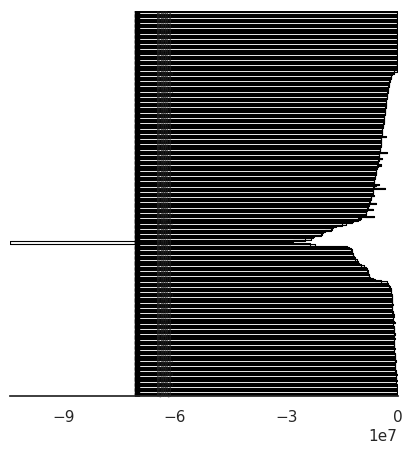

In [18]:
df['pop'] = df.haplo_ID
df['is_north'] = (df.north == 1).astype(int)
df['is_south'] = (df.north == -1).astype(int)
df = df.sort_values(['pop', 'chrom', 'start'])

df_f = pd.concat([df_filt, gap_df])
df_f['pop'] = df_f.haplo_ID
df_f['is_north'] = (df_f.north == 1).astype(int)
df_f['is_south'] = (df_f.north == -1).astype(int)
df_f['is_filtered'] = (df_f.north == 0).astype(int)
df_f = df_f.sort_values(['pop', 'chrom', 'pos', 'is_north', 'is_south'])

haplo_ID_list = list(df.haplo_ID.unique())

north_south_segment_lists = []
for sample_name in haplo_ID_list:
    north_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 1), ['pos', 'end_pos']].itertuples(index=False, name=None))
    south_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 0), ['pos', 'end_pos']].itertuples(index=False, name=None))
    north_south_segment_lists.append((north_tuples, south_tuples))
    
newick_str = tree_newick(haplo_ID_list, north_south_segment_lists, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

order_tree(tree, key=order_fun)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

leaf_info = plot_tree(tree, ax1, fontsize=2)
haplo_ID_sorting, x, y = zip(*leaf_info)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made lar

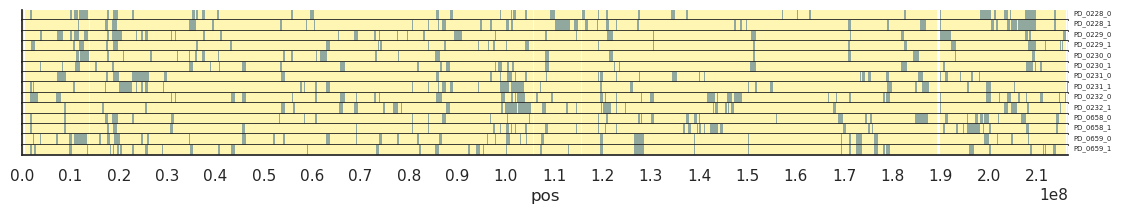

In [19]:
result_order = ['Mahale, Tanzania']
df_f["Origin"] = df_f.individual.map(dict(zip(meta_data_samples.PGDP_ID, meta_data_samples.Origin)))
for o in result_order: 
    plot_df = stairs(df_f.loc[df_f.Origin == o]).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
    g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.135, aspect=100,
                    row_order=plot_df.haplo_ID.unique(), margin_titles=True, gridspec_kws={'hspace':0.0})
    # Non-large version is made with height = 0.1 and aspect 150.
    g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
    g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=yellow_south,
    linewidth=0,
    capstyle='butt')
    g.map(plt.fill_between, 
    'pos', 
    'is_filtered', 
    y2=0,
    color="#ffffff",
    linewidth=0,
    capstyle='butt')
    g.set_titles(col_template="", row_template="")
    g.set(yticklabels=[])  
    g.set(ylabel=None)
    g.tick_params(left=False)  # remove the ticks 
    for label, ax in zip(plot_df.haplo_ID.unique(), g.axes.flat):
        ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
        ax.set_ylim(0, 1)    
        ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
        ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
        g.savefig("../figures/chr1_{}_filt075_large.pdf".format(o))

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made lar

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

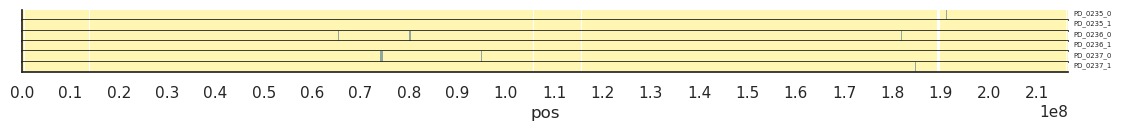

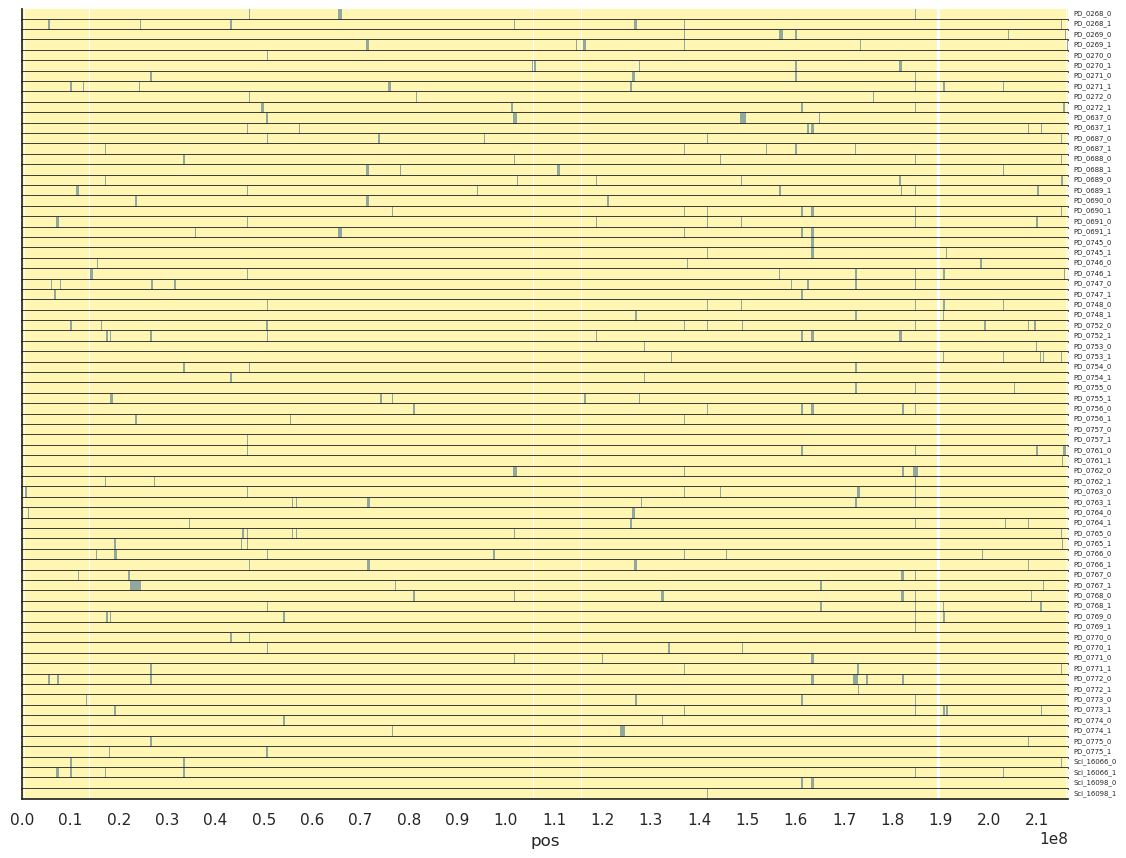

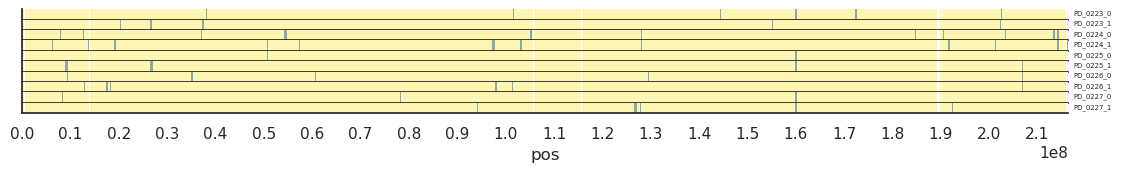

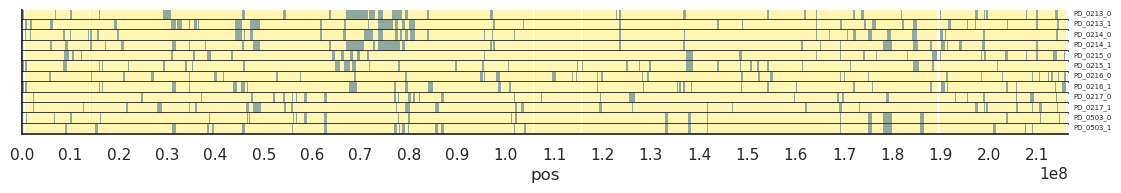

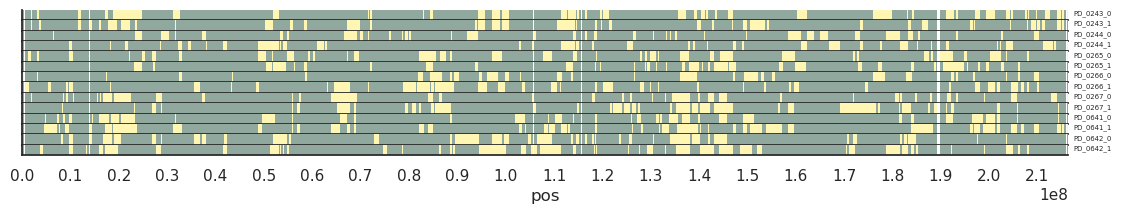

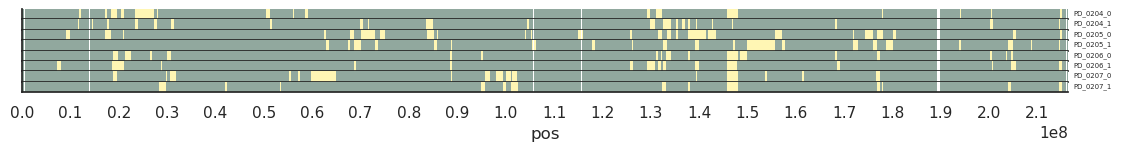

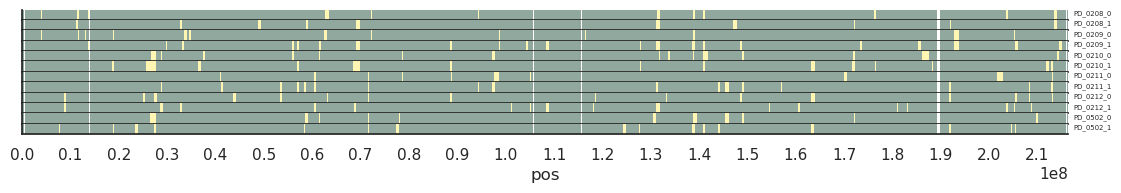

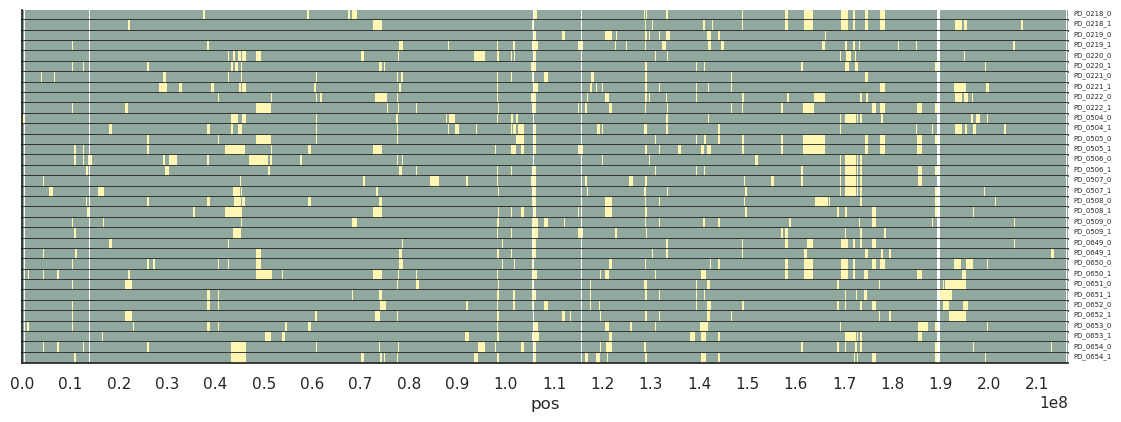

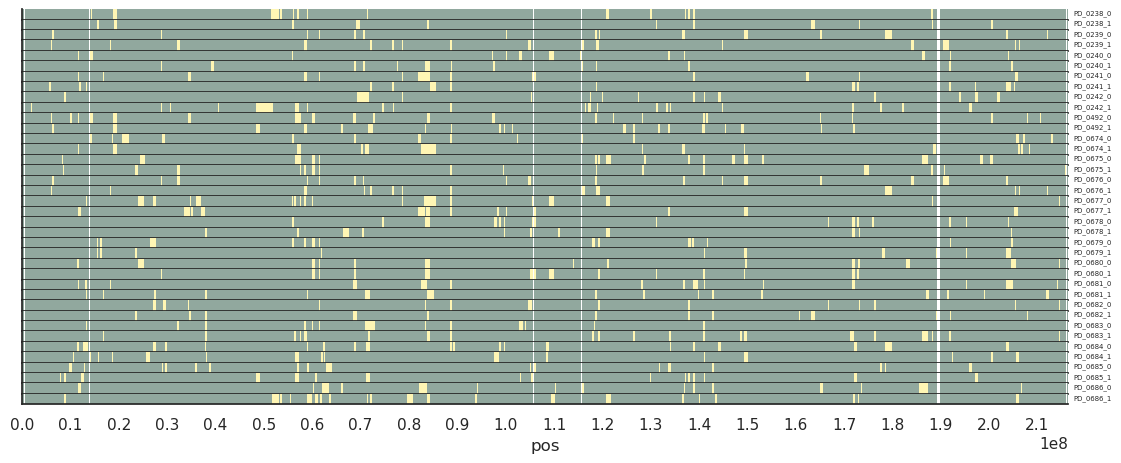

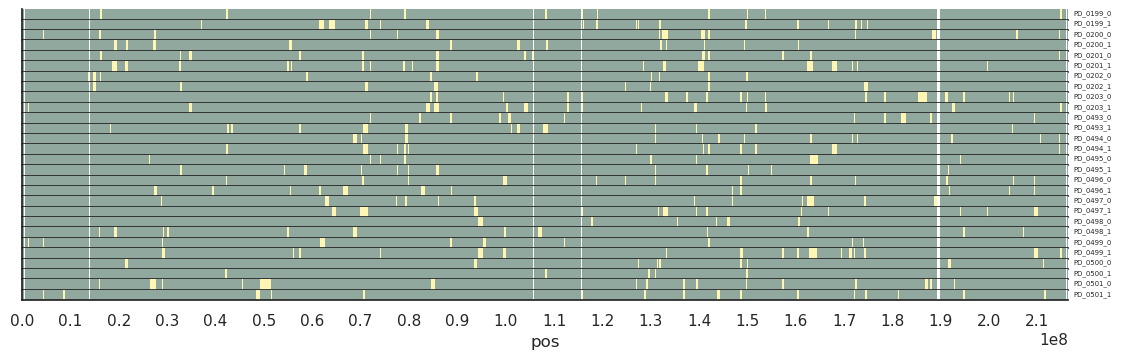

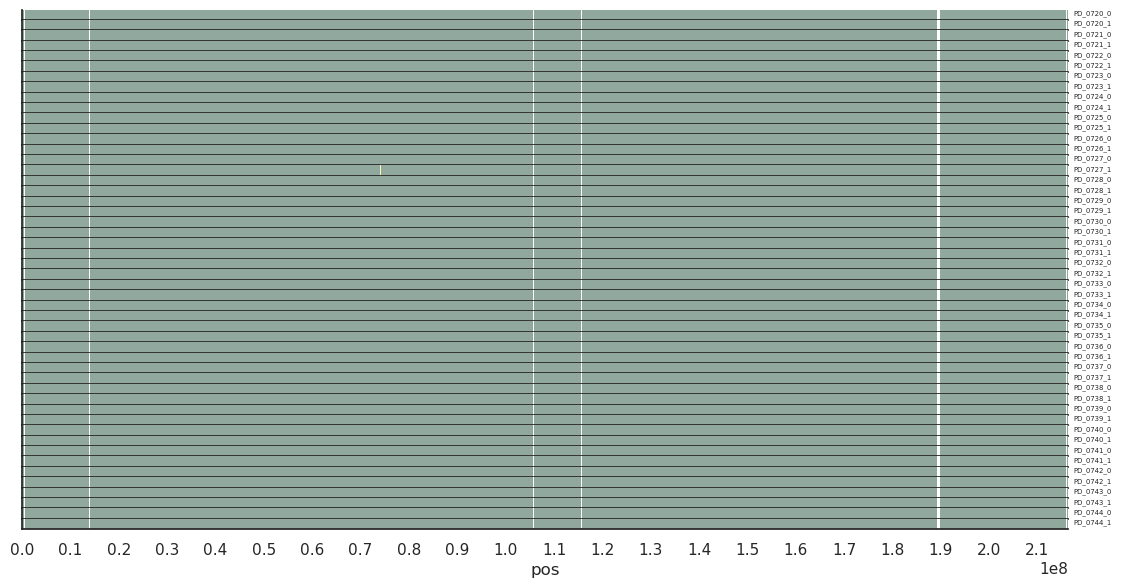

In [134]:
result_order = ['Selous, Tanzania', 'Mikumi, Tanzania', 'Udzungwa, Tanzania', 'Ruaha, Tanzania',
       'Tarangire, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania', 
             'Lake Manyara, Tanzania', 'Serengeti, Tanzania', 'Gog Woreda, Gambella region, Ethiopia']
df_f["Origin"] = df_f.individual.map(dict(zip(meta_data_samples.PGDP_ID, meta_data_samples.Origin)))
for o in result_order: 
    plot_df = stairs(df_f.loc[df_f.Origin == o]).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
    g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.135, aspect=100,
                    row_order=plot_df.haplo_ID.unique(), margin_titles=True, gridspec_kws={'hspace':0.0})
    # Non-large version is made with height = 0.1 and aspect 150.
    g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
    g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=yellow_south,
    linewidth=0,
    capstyle='butt')
    g.map(plt.fill_between, 
    'pos', 
    'is_filtered', 
    y2=0,
    color="#ffffff",
    linewidth=0,
    capstyle='butt')
    g.set_titles(col_template="", row_template="")
    g.set(yticklabels=[])  
    g.set(ylabel=None)
    g.tick_params(left=False)  # remove the ticks 
    for label, ax in zip(plot_df.haplo_ID.unique(), g.axes.flat):
        ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
        ax.set_ylim(0, 1)    
        ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
        ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
        g.savefig("../figures/chr1_{}_filt075_large.pdf".format(o))

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made lar

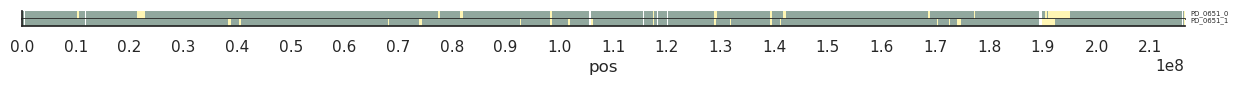

In [133]:
input_df = df_f.loc[df_f.haplo_ID.isin(["PD_0651_0", "PD_0651_1"])]

plot_df = stairs(input_df).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.1, aspect=150,
                    row_order=plot_df.haplo_ID.unique(), margin_titles=True, gridspec_kws={'hspace':0.0})

g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=yellow_south,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_filtered', 
    y2=0,
    color="#ffffff",
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(plot_df.haplo_ID.unique(), g.axes.flat):
    ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(plot_df.pos)+1, 10000000))

Chr8 plot workflow

In [20]:
df = length_df.loc[length_df.chrom == "chr8"]
df_l = []
for c in df.chrom.unique():
    print(c)
    l_df = df.loc[df.chrom == c].copy()
    if c == "female_chrX" or c == "all_chrX":
        c = "chrX"
        l_df = l_df.loc[~(l_df.individual.isin(male_IDs) & (l_df.haplotype == "1"))]
    r_df = recomb_df.loc[(recomb_df.chromosome == c)]
    pos_mapping = dict(zip(r_df.position, r_df["Genetic_Map(cM)"]))
    l_df["start_cM"] = l_df.pos.map(pos_mapping)
    l_df["end"] = l_df.end_pos + 1
    l_df["end_cM"] = l_df.end.map(pos_mapping)
    call_df = c_r_g_df.loc[c_r_g_df.chrom == c]
    df_call_filt = []
    df_l.append(l_df)
df = pd.concat(df_l)
callable_df = call_df.loc[call_df.callable_frac > 0.75].reset_index()
c_s = callable_df.iloc[0].start
c_e, old_end = callable_df.iloc[0].start, 0
# Seems weird, but how makes it work correctly for identifying intervals in filters
r_s = callable_df.iloc[0].cM
sub_df_l, gap_df_l = [], []
for i, row in callable_df.iterrows():
    if c_e != row.start:# or i+1 == len(callable_df):
        sub_df = df.loc[(df.end_pos > c_s) & (df.pos < c_e)]
        sub_df.loc[sub_df.start_cM < r_s, "start_cM"] = r_s
        sub_df.loc[sub_df.end_cM > row.end_cM, "end_cM"] = row.end_cM
        sub_df.loc[sub_df.pos < c_s, "pos"] = c_s
        sub_df.loc[sub_df.end_pos > c_e, "end_pos"] = c_e
        sub_df_l.append(sub_df)
        # Add start/ends
        start_df = sub_df.loc[sub_df.pos == c_s].copy()
        start_df.end_pos, start_df.end_cM, start_df.north = c_s, r_s, 0
        end_df = sub_df.loc[sub_df.end_pos == c_e].copy()
        end_df.pos, end_df.cM, end_df.north = c_e, r_s, 0
        gap_df_l.append(start_df), gap_df_l.append(end_df)
        # update df_l with new slice of fragment_df
        c_s, c_e, r_s = row.start, row.end, row.cM
    else:
        c_e = row.end
df_filt = pd.concat(sub_df_l)
gap_df = pd.concat(gap_df_l)

chr8


In [15]:
df_filt

,pos,end_pos,length,reference,n/s,individual,haplotype,chrom,haplo_ID,start,north,total_north,start_cM,end,end_cM
0,100000,6700000,6742942,"Kindae, Zambia",0,Sci_16066,0,chr8,Sci_16066_0,4263,-1,-6742942,2.034545,6747205,12.705919
0,100000,6700000,11427940,"Kindae, Zambia",0,Sci_16066,1,chr8,Sci_16066_1,4263,-1,-11427940,2.034545,11432203,14.416518
0,100000,6700000,9469778,"Kindae, Zambia",0,Sci_16098,0,chr8,Sci_16098_0,4263,-1,-9469778,2.034545,9474041,14.416518
0,100000,6700000,13484618,"Kindae, Zambia",0,Sci_16098,1,chr8,Sci_16098_1,4263,-1,-13484618,2.034545,13488881,14.416518
0,100000,1533443,1529181,"Hamadryas, Ethiopia",1,Sci_30877,0,chr8,Sci_30877_0,4263,1,1529181,2.034545,1533444,4.856794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,101400000,111796764,33168081,"Kindae, Zambia",0,PD_0775,1,chr8,PD_0775_1,78628684,-1,-33168081,81.066202,111796765,86.264565
29,111796765,115852242,4055478,"Ursinus, Zambia",0,PD_0775,1,chr8,PD_0775_1,111796765,-1,-4055478,86.264565,115852243,88.829502
30,115852243,116069259,217017,"Hamadryas, Ethiopia",1,PD_0775,1,chr8,PD_0775_1,115852243,1,217017,88.829502,116069260,88.989079
31,116069260,116633120,563861,"Ursinus, Zambia",0,PD_0775,1,chr8,PD_0775_1,116069260,-1,-563861,88.989079,116633121,89.427331


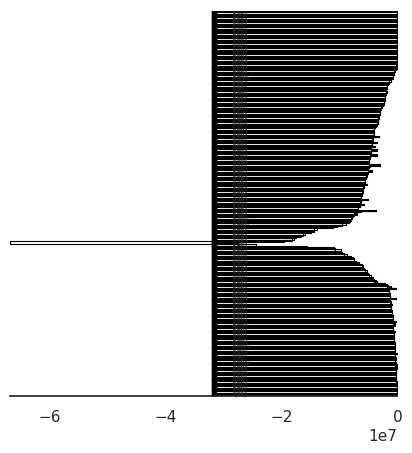

In [21]:
df['pop'] = df.haplo_ID
df['is_north'] = (df.north == 1).astype(int)
df['is_south'] = (df.north == -1).astype(int)
df = df.sort_values(['pop', 'chrom', 'start'])

df_f = pd.concat([df_filt, gap_df])
df_f['pop'] = df_f.haplo_ID
df_f['is_north'] = (df_f.north == 1).astype(int)
df_f['is_south'] = (df_f.north == -1).astype(int)
df_f['is_filtered'] = (df_f.north == 0).astype(int)
df_f = df_f.sort_values(['pop', 'chrom', 'pos', 'is_north', 'is_south'])

haplo_ID_list = list(df.haplo_ID.unique())

north_south_segment_lists = []
for sample_name in haplo_ID_list:
    north_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 1), ['pos', 'end_pos']].itertuples(index=False, name=None))
    south_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 0), ['pos', 'end_pos']].itertuples(index=False, name=None))
    north_south_segment_lists.append((north_tuples, south_tuples))
    
newick_str = tree_newick(haplo_ID_list, north_south_segment_lists, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

order_tree(tree, key=order_fun)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

leaf_info = plot_tree(tree, ax1, fontsize=2)
haplo_ID_sorting, x, y = zip(*leaf_info)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The bottom and top margins cannot be made lar

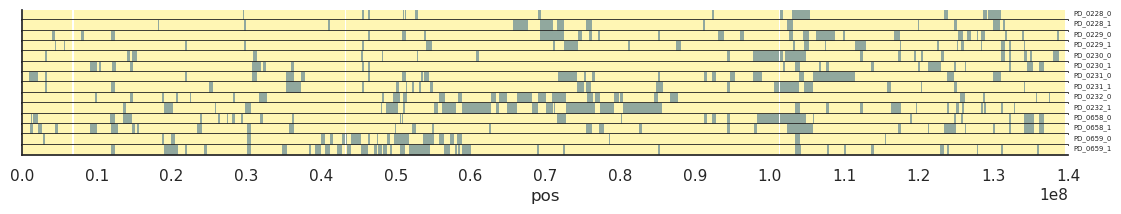

In [22]:
result_order = ['Mahale, Tanzania']
df_f["Origin"] = df_f.individual.map(dict(zip(meta_data_samples.PGDP_ID, meta_data_samples.Origin)))
for o in result_order: 
    plot_df = stairs(df_f.loc[df_f.Origin == o]).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
    g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.135, aspect=100,
                    row_order=plot_df.haplo_ID.unique(), margin_titles=True, gridspec_kws={'hspace':0.0})
    # Non-large version is made with height = 0.1 and aspect 150.
    g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
    g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=yellow_south,
    linewidth=0,
    capstyle='butt')
    g.map(plt.fill_between, 
    'pos', 
    'is_filtered', 
    y2=0,
    color="#ffffff",
    linewidth=0,
    capstyle='butt')
    g.set_titles(col_template="", row_template="")
    g.set(yticklabels=[])  
    g.set(ylabel=None)
    g.tick_params(left=False)  # remove the ticks 
    for label, ax in zip(plot_df.haplo_ID.unique(), g.axes.flat):
        ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
        ax.set_ylim(0, 1)    
        ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
        ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
        g.savefig("../figures/chr8_{}_filt075_large.pdf".format(o))

In [ ]:
result_order = ['Selous, Tanzania', 'Mikumi, Tanzania', 'Udzungwa, Tanzania', 'Ruaha, Tanzania',
       'Tarangire, Tanzania', 'Arusha, Tanzania', 'Ngorongoro, Tanzania', 'Gombe, Tanzania', 
             'Lake Manyara, Tanzania', 'Serengeti, Tanzania', 'Gog Woreda, Gambella region, Ethiopia']
df_f["Origin"] = df_f.individual.map(dict(zip(meta_data_samples.PGDP_ID, meta_data_samples.Origin)))
#df_sorted = stairs(df_f).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
df_f = df_sorted.loc[df_sorted.Origin.isin(result_order)]

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

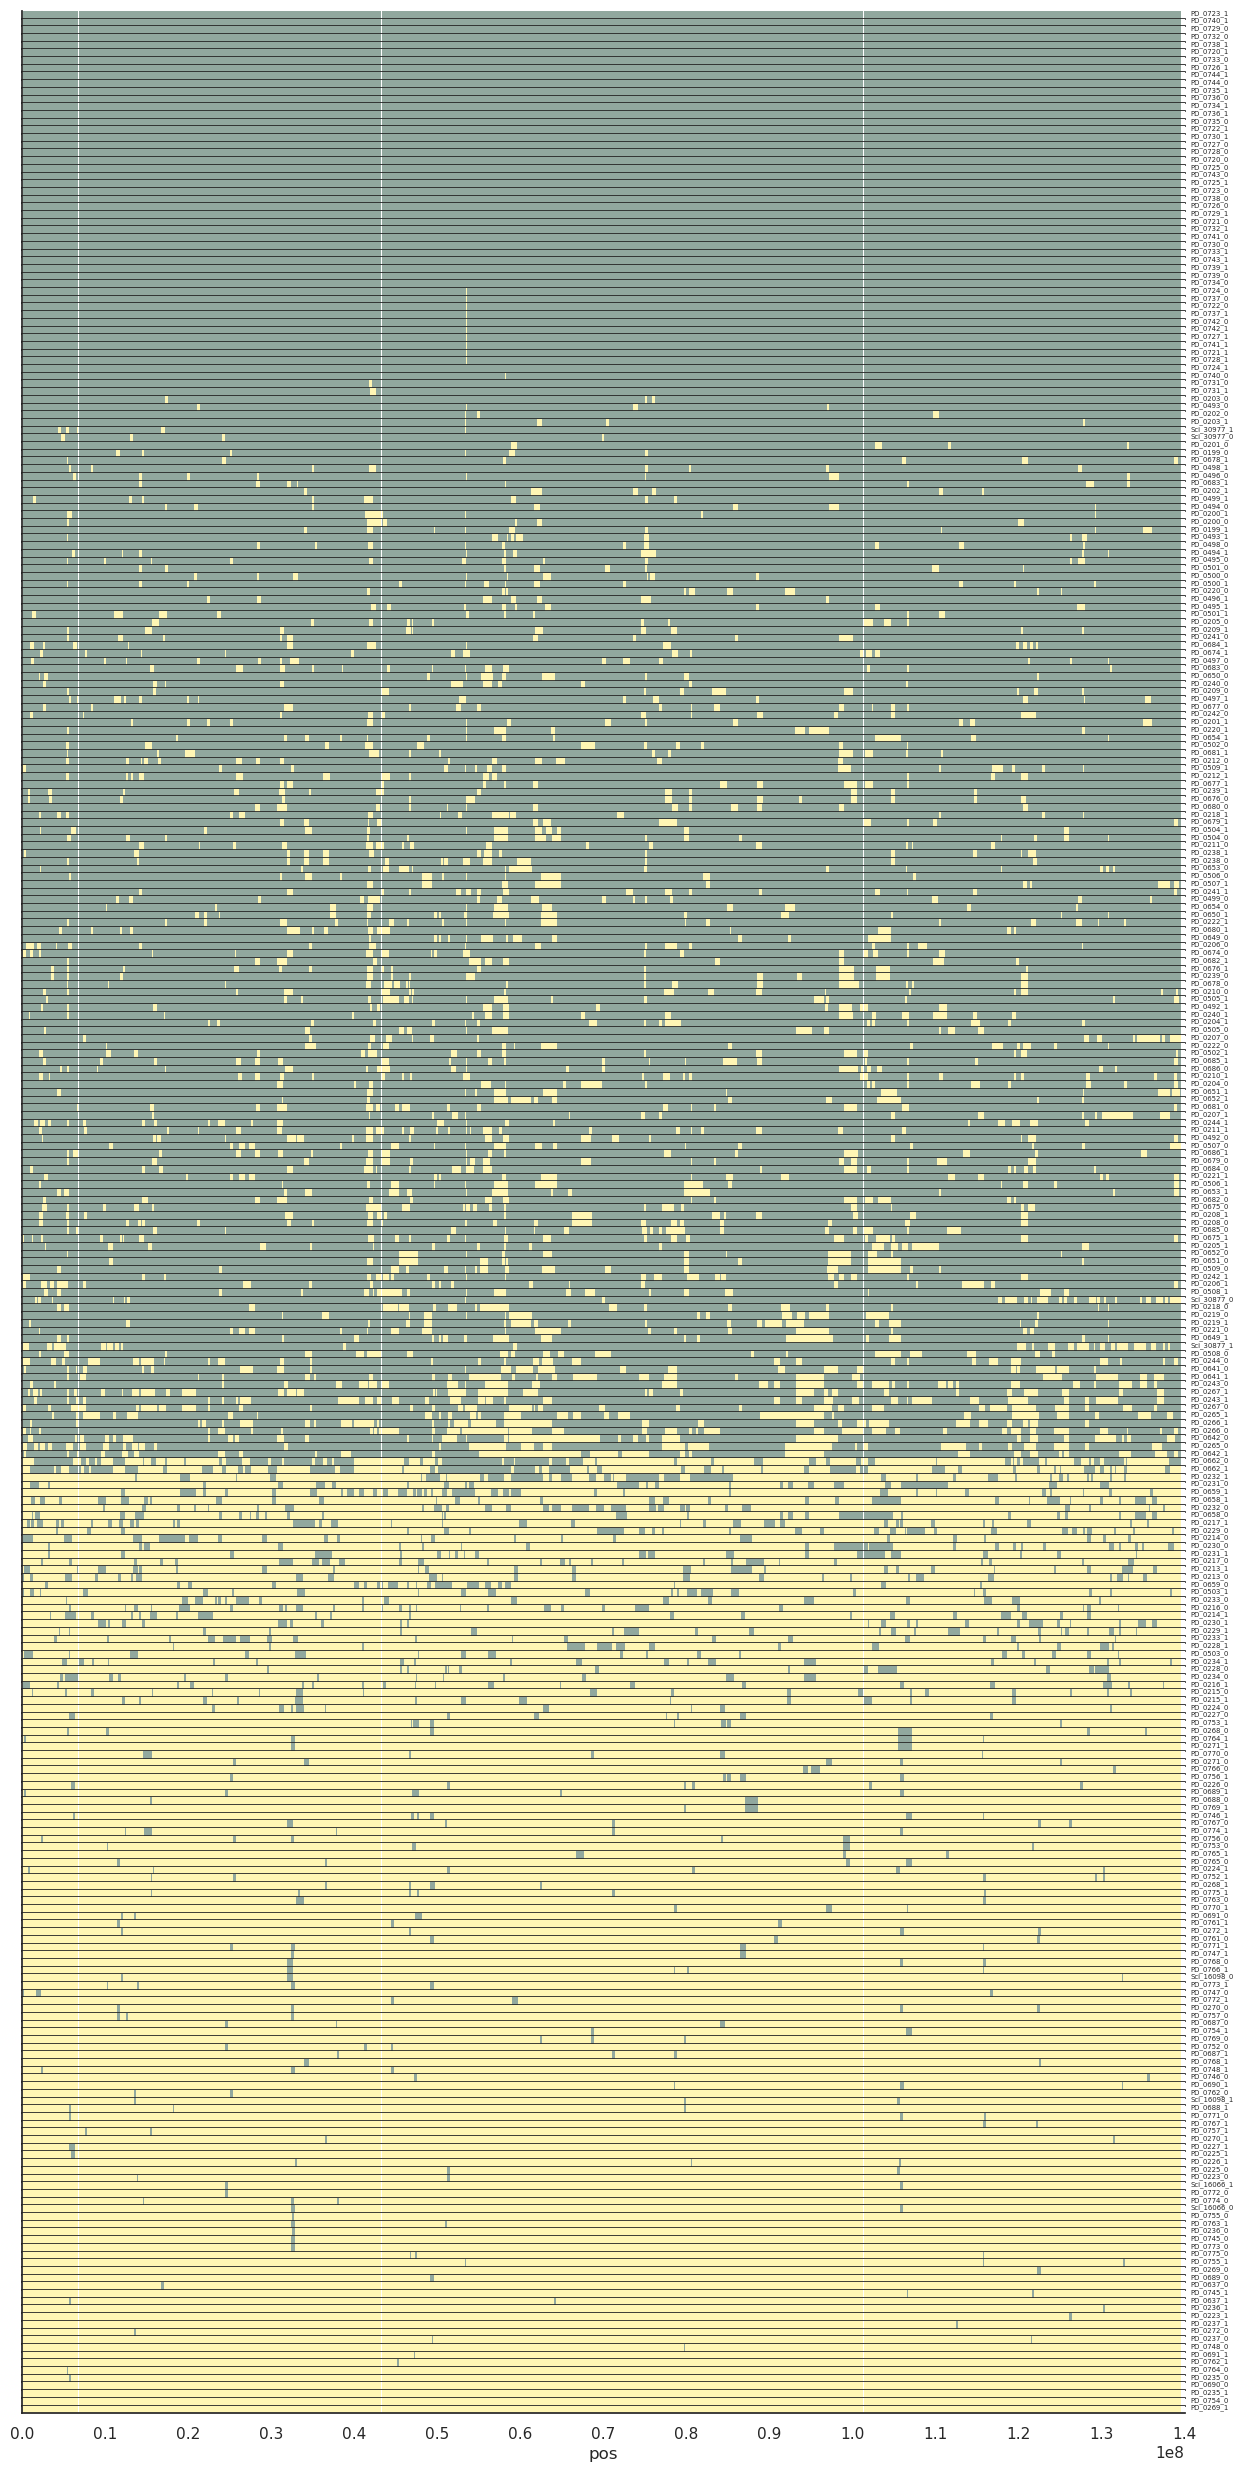

In [22]:
def stairs(df, start='pos', end='end_pos', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

plot_df = stairs(df_f).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.1, aspect=150,
                    row_order=haplo_ID_sorting, margin_titles=True, gridspec_kws={'hspace':0.0})

g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=yellow_south,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_filtered', 
    y2=0,
    color="#ffffff",
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(haplo_ID_sorting, g.axes.flat):
    ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
g.savefig("../figures/chr8_tanzfocus_filt075.pdf")

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


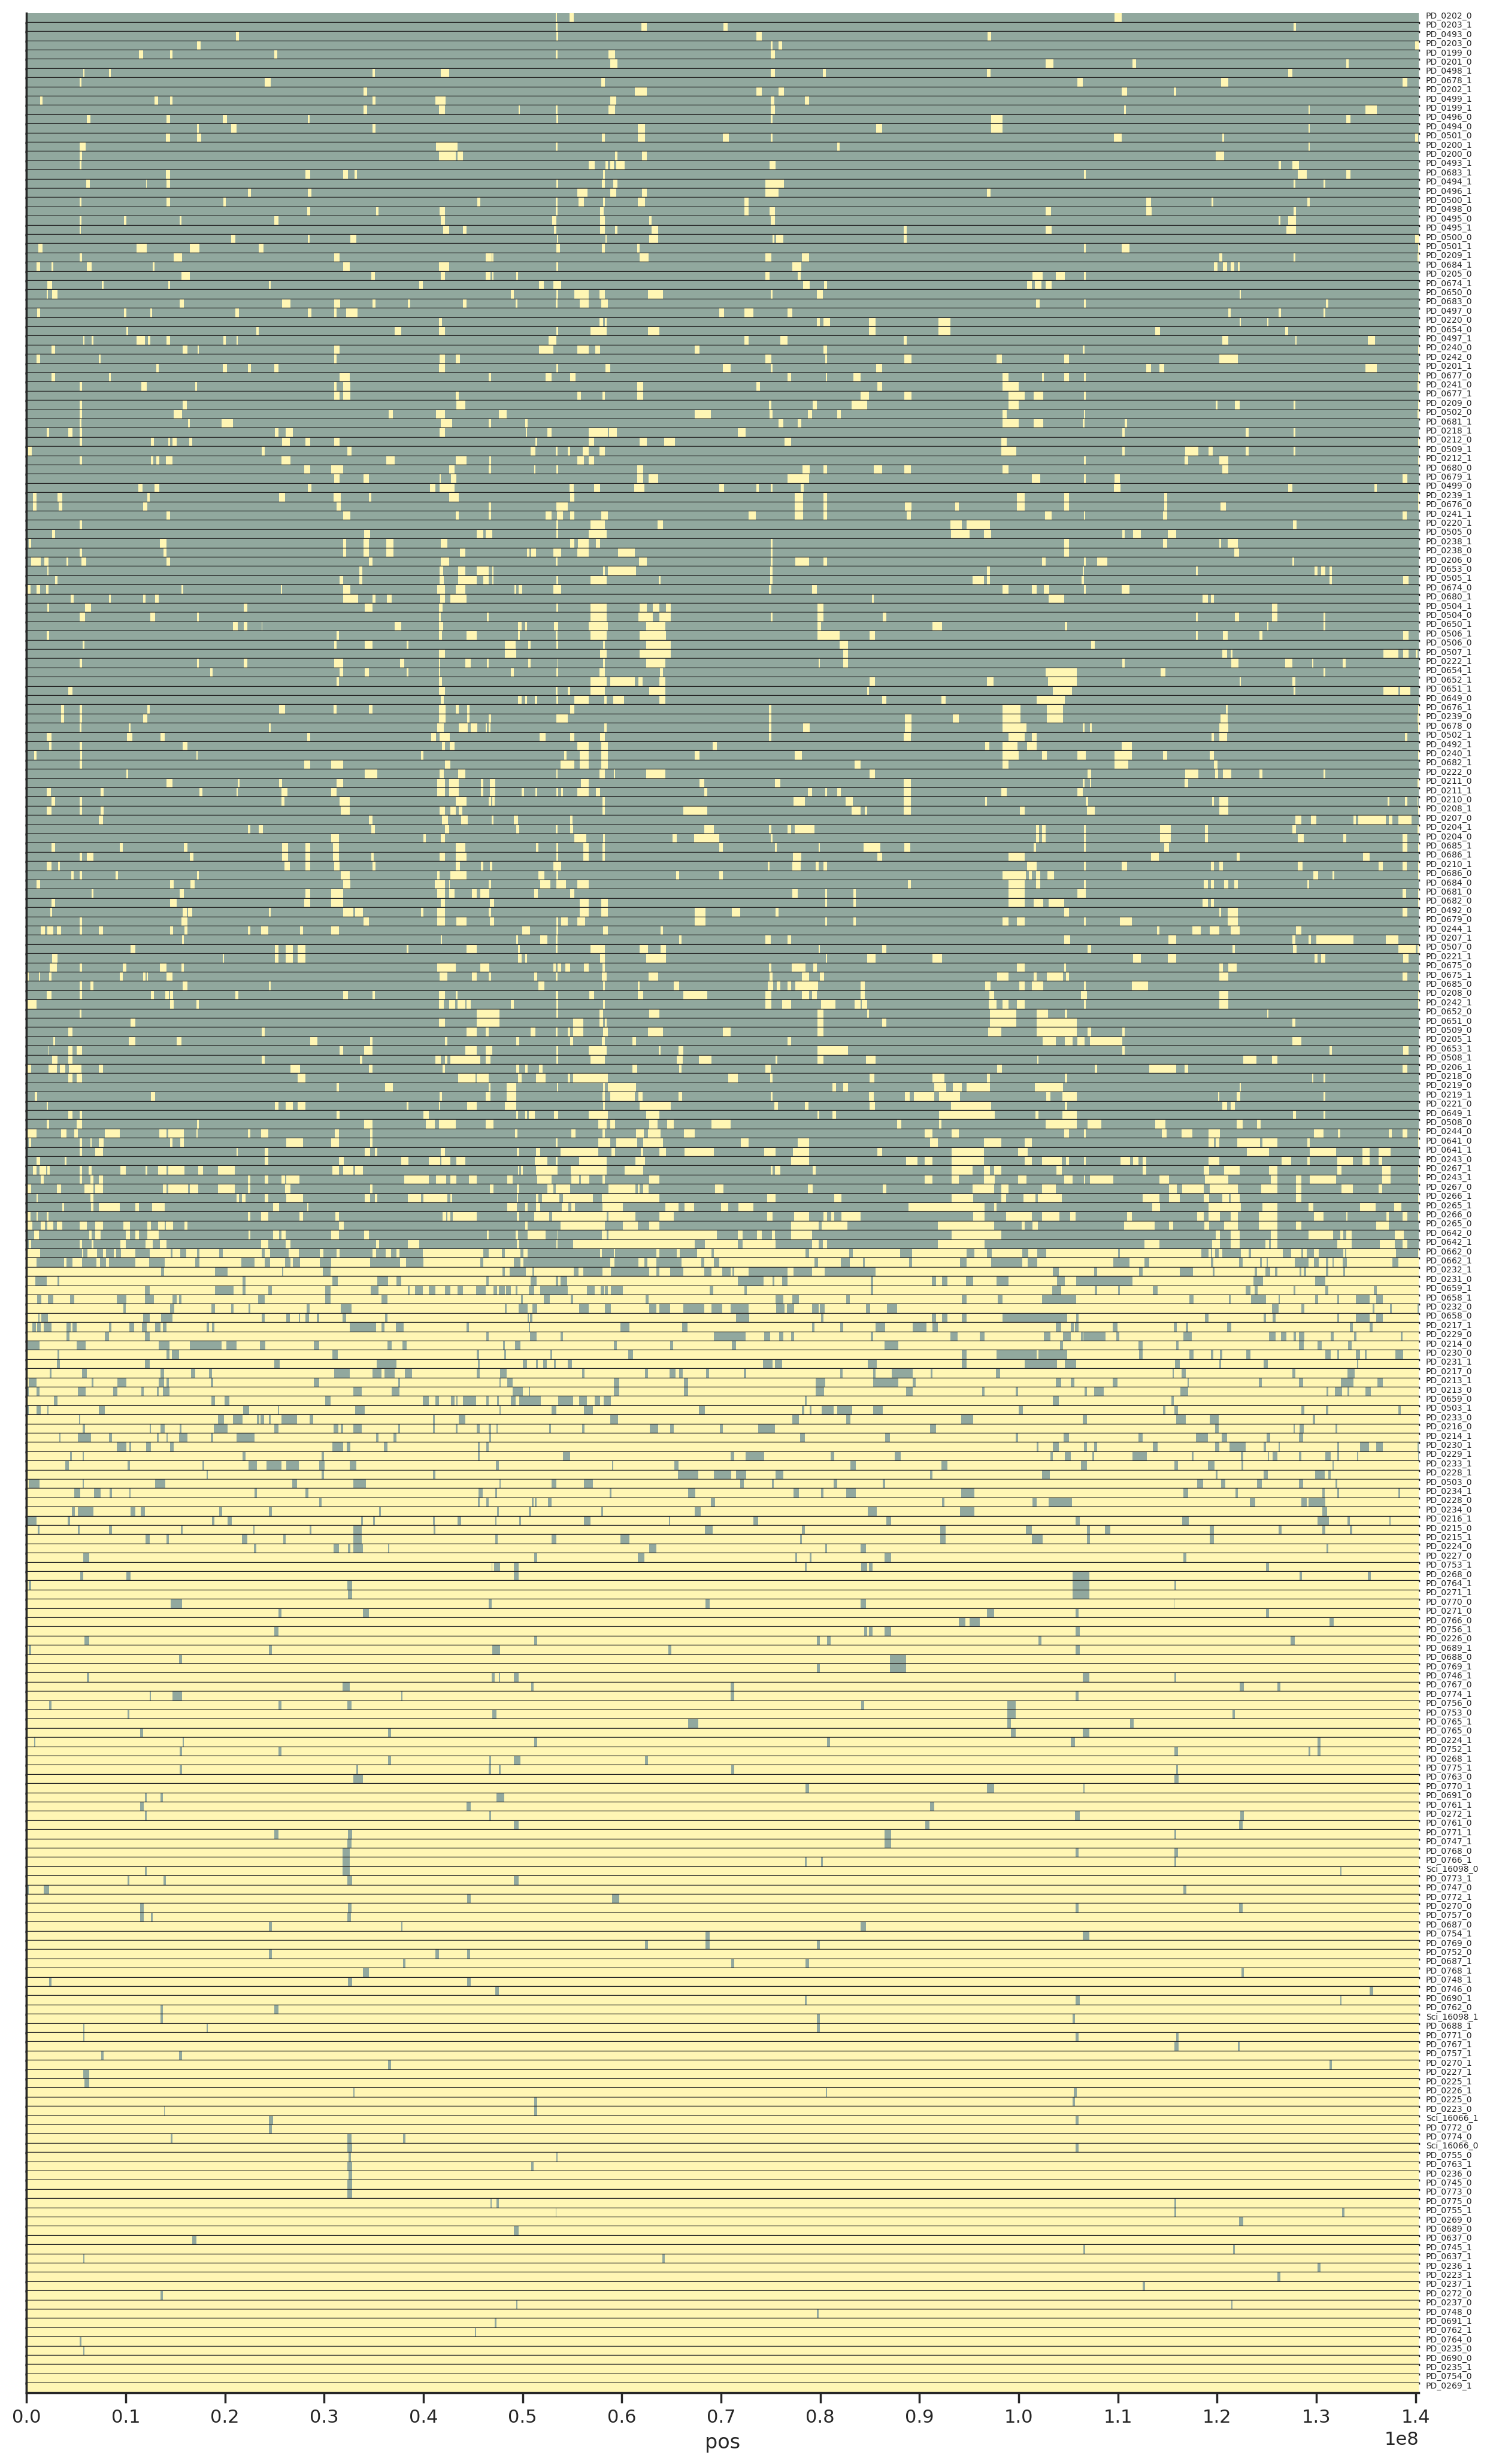

In [16]:
g = sns.FacetGrid(stairs(df), col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.1, aspect=150,
                    row_order=haplo_ID_sorting, margin_titles=True, gridspec_kws={'hspace':0.0})
plot_df = stairs(df)
g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=yellow_south,
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(haplo_ID_sorting, g.axes.flat):
    ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
g.savefig("../figures/chr8_tanzania.png")

Doing the same for Ethiopian olives

In [16]:
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering_sci.txt", sep =" ")
rfmix_path = "/home/eriks/baboondiversity/people/eriks/second_analysis_baboons/steps/rfmix_gen100/eth_olive_focus/"
mapping_df = pd.read_csv(rfmix_path + "ref_names.txt", sep = "\t", names=["ID", "Origin"])

pop_mapping = {}
o_order = sorted((mapping_df.Origin.unique()))
for o in range(len((mapping_df.Origin.unique()))):
    pop_mapping[o_order[o]] = o

north_south_mapping = {'Hamadryas, Ethiopia': 1,
 'Cynocephalus, Central Tanzania': 0,
 'Papio, Senegal': 0,
 'Anubis, Tanzania': 0}

df_l = []
for chrom in ["chr{}".format(x) for x in (range(1, 21))]+["all_chrX", "female_chrX"]:
    print(chrom)
    input_file = rfmix_path + "{}.msp.tsv".format(chrom)
    chr_df = pd.read_csv(input_file, sep = "\t", header=1)
    file = open(input_file, 'r')
    line1 = file.readline()
    file.close()
    number_subpop_mapping = {}
    for subpop in line1.strip().split("\t"):
        # Splitting to create lists containing two values - subpop and number.
        subpop_number = subpop.split(": ")[-1].split("=")
        number_subpop_mapping[int(subpop_number[1])] = subpop_number[0]
    for hap in chr_df.columns[6:]:
        paint_df = create_paint_df_ind_compressed(chr_df, hap, number_subpop_mapping, north_south_mapping)
        paint_df["chrom"] = "{}".format(chrom)
        df_l.append(paint_df)
length_df = pd.concat(df_l)


chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


In [17]:
length_df["haplo_ID"] = length_df.individual +"_"+ length_df.haplotype
length_df["start"] = length_df.pos
length_df["north"] = length_df["n/s"]*2-1
length_df["total_north"] = length_df["north"]*length_df.length
male_IDs = meta_data_samples.loc[meta_data_samples.Sex == "M"].PGDP_ID

# Colors
hamadryas_north = '#91a89e'
olive_north = '#495F43'
yellow_south = '#FFF6B4'

In [18]:
tanzania = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Central Tanzania",
                                                                "Anubis, Tanzania",
                                                                "Cynocephalus, Western Tanzania"])].PGDP_ID
olive = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Anubis, Tanzania"])].PGDP_ID
eth = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Anubis, Ethiopia"])].PGDP_ID
yellow = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Central Tanzania",
                                                                "Cynocephalus, Western Tanzania"])].PGDP_ID
western = meta_data_samples.loc[meta_data_samples.C_origin.isin(["Cynocephalus, Western Tanzania"])].PGDP_ID
ruaha = meta_data_samples.loc[meta_data_samples.Origin == "Ruaha, Tanzania"].PGDP_ID
df_eth = length_df.loc[length_df.individual.isin(eth)]

df = df_eth.loc[df_eth.chrom == "all_chrX"]
df = df.loc[~(df.individual.isin(male_IDs) & (df.haplotype == "1"))]

In [46]:

df_l = []
for c in df.chrom.unique():
    print(c)
    l_df = df.loc[df.chrom == c].copy()
    if c == "female_chrX" or c == "all_chrX":
        c = "chrX"
    r_df = recomb_df.loc[(recomb_df.chromosome == c)]
    pos_mapping = dict(zip(r_df.position, r_df["Genetic_Map(cM)"]))
    l_df["start_cM"] = l_df.pos.map(pos_mapping)
    l_df["end"] = l_df.end_pos + 1
    l_df["end_cM"] = l_df.end.map(pos_mapping)
    call_df = c_r_g_df.loc[c_r_g_df.chrom == c]
    df_call_filt = []
    df_l.append(l_df)
df = pd.concat(df_l)
callable_df = call_df.loc[call_df.callable_frac > 0.75].reset_index()
c_s = callable_df.iloc[0].start
c_e, old_end = callable_df.iloc[0].start, 0
# Seems weird, but how makes it work correctly for identifying intervals in filters
r_s = callable_df.iloc[0].cM
sub_df_l, gap_df_l = [], []
for i, row in callable_df.iterrows():
    if c_e != row.start:# or i+1 == len(callable_df):
        sub_df = df.loc[(df.end_pos > c_s) & (df.pos < c_e)]
        sub_df.loc[sub_df.start_cM < r_s, "start_cM"] = r_s
        sub_df.loc[sub_df.end_cM > row.end_cM, "end_cM"] = row.end_cM
        sub_df.loc[sub_df.pos < c_s, "pos"] = c_s
        sub_df.loc[sub_df.end_pos > c_e, "end_pos"] = c_e
        sub_df_l.append(sub_df)
        # Add start/ends
        start_df = sub_df.loc[sub_df.pos == c_s].copy()
        start_df.end_pos, start_df.end_cM, start_df.north = c_s, r_s, 0
        end_df = sub_df.loc[sub_df.end_pos == c_e].copy()
        end_df.pos, end_df.cM, end_df.north = c_e, r_s, 0
        gap_df_l.append(start_df), gap_df_l.append(end_df)
        # update df_l with new slice of fragment_df
        c_s, c_e, r_s = row.start, row.end, row.cM
    else:
        c_e = row.end
df_filt = pd.concat(sub_df_l)
gap_df = pd.concat(gap_df_l)

all_chrX


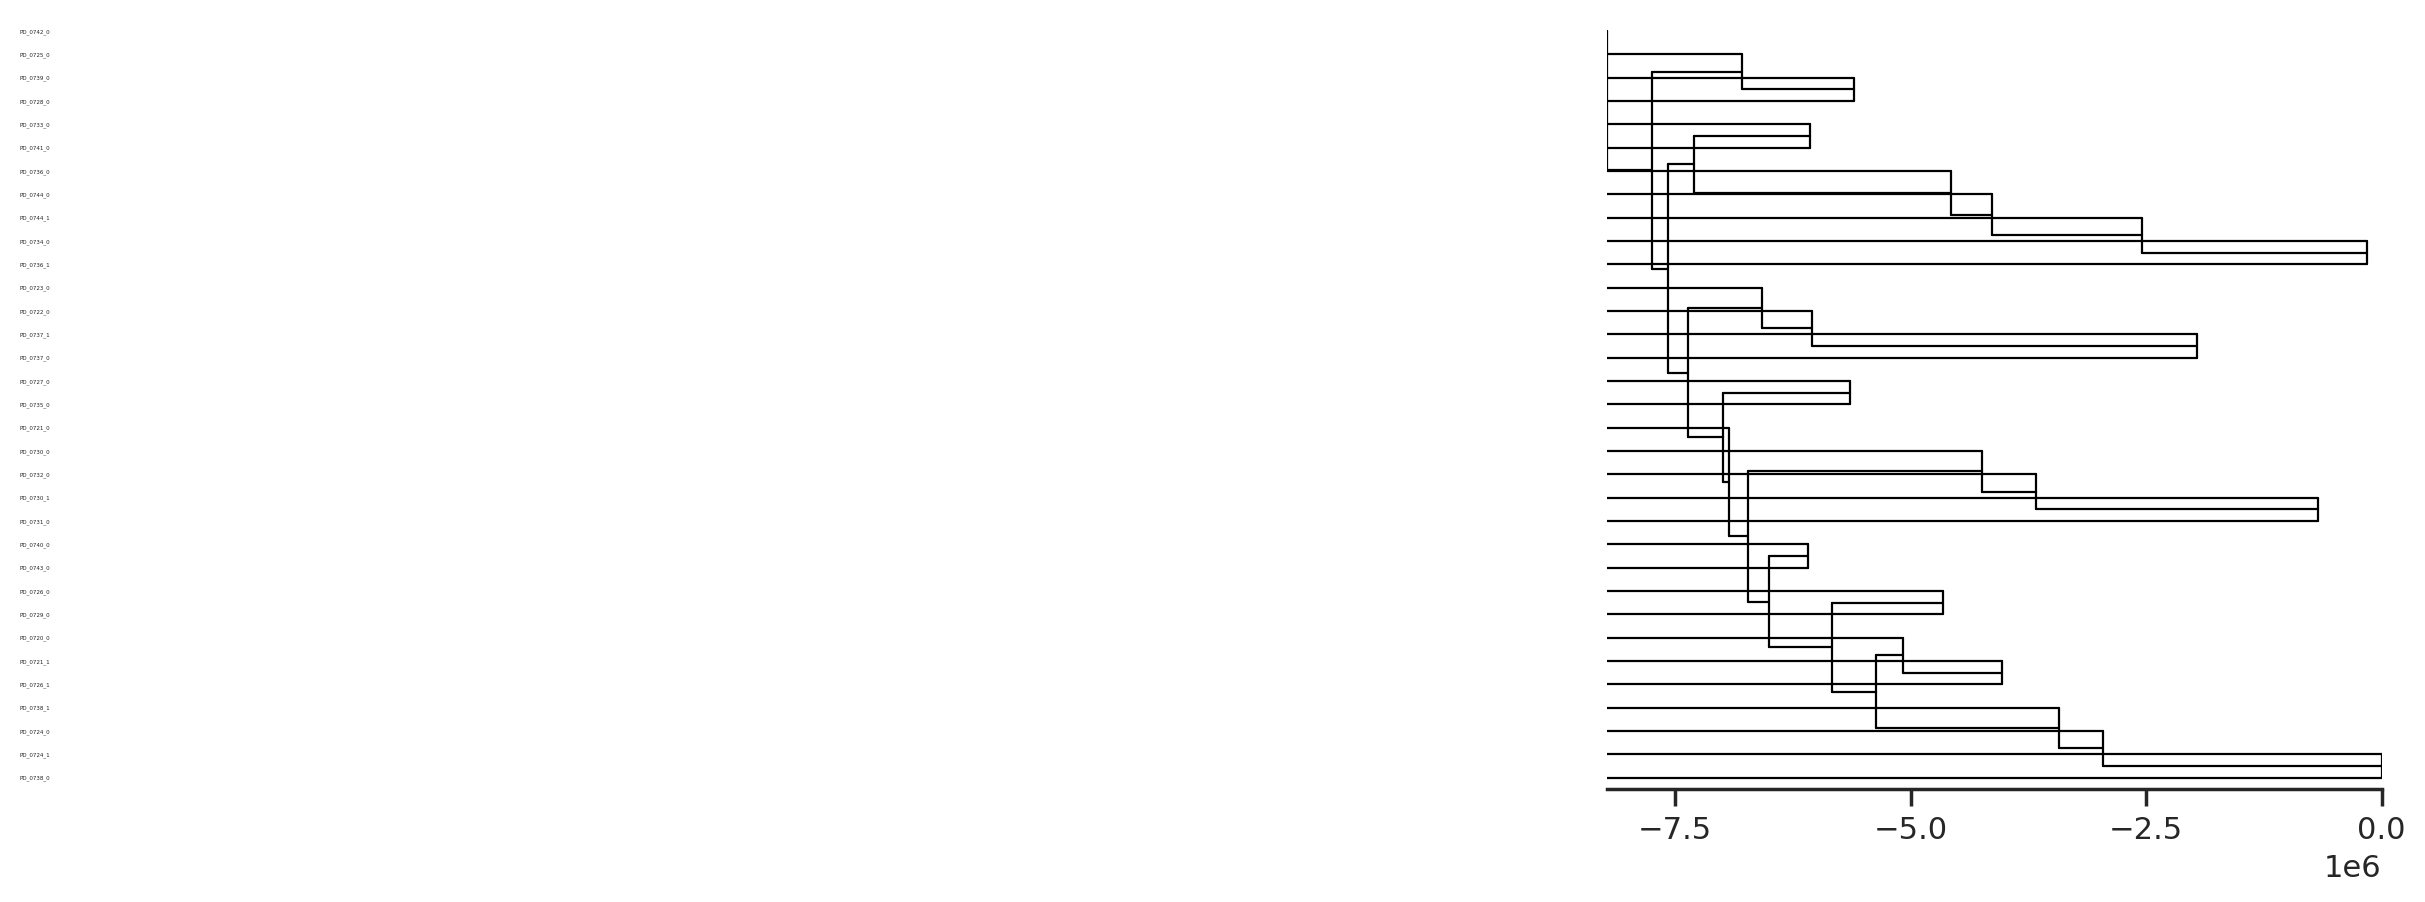

In [47]:
df['pop'] = df.haplo_ID
df['is_north'] = (df.north == 1).astype(int)
df['is_south'] = (df.north == -1).astype(int)
df = df.sort_values(['pop', 'chrom', 'start'])

df_f = pd.concat([df_filt, gap_df])
df_f['pop'] = df_f.haplo_ID
df_f['is_north'] = (df_f.north == 1).astype(int)
df_f['is_south'] = (df_f.north == -1).astype(int)
df_f['is_filtered'] = (df_f.north == 0).astype(int)
df_f = df_f.sort_values(['pop', 'chrom', 'pos', 'is_north', 'is_south'])

haplo_ID_list = list(df.haplo_ID.unique())

north_south_segment_lists = []
for sample_name in haplo_ID_list:
    north_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 1), ['pos', 'end_pos']].itertuples(index=False, name=None))
    south_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 0), ['pos', 'end_pos']].itertuples(index=False, name=None))
    north_south_segment_lists.append((north_tuples, south_tuples))

def tot_overlap(arr1, arr2):
    """total overlap of two lists of intervals"""
    tot = 0
    i = j = 0
    n = len(arr1)
    m = len(arr2)
    while i < n and j < m:
        l = max(arr1[i][0], arr2[j][0])
        r = min(arr1[i][1], arr2[j][1])
        if l <= r: 
            tot += r - l
        if arr1[i][1] < arr2[j][1]:
            i += 1
        else:
            j += 1
    return tot

def proportion_same_ancestry(*args):
    """proportion of chromsome with same ancestry"""
    a, b, case_sensitive = args
    ovl = tot_overlap(a[0], b[0]) + tot_overlap(a[1], b[1])
    return 77000000 - ovl
    
newick_str = tree_newick(haplo_ID_list, north_south_segment_lists, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

def order_fun(c):
    """order child clades so that leaves in left has more north ancestry"""
    leaf_names = [x.name for x in c.get_leaves()]
    idx = [haplo_ID_list.index(x) for x in leaf_names]
    return sum(e-s for i in idx for (s, e) in north_south_segment_lists[i][1]) - sum(e-s for i in idx for (s, e) in north_south_segment_lists[i][0])

order_tree(tree, key=order_fun)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

leaf_info = plot_tree(tree, ax1, fontsize=2)
haplo_ID_sorting, x, y = zip(*leaf_info)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


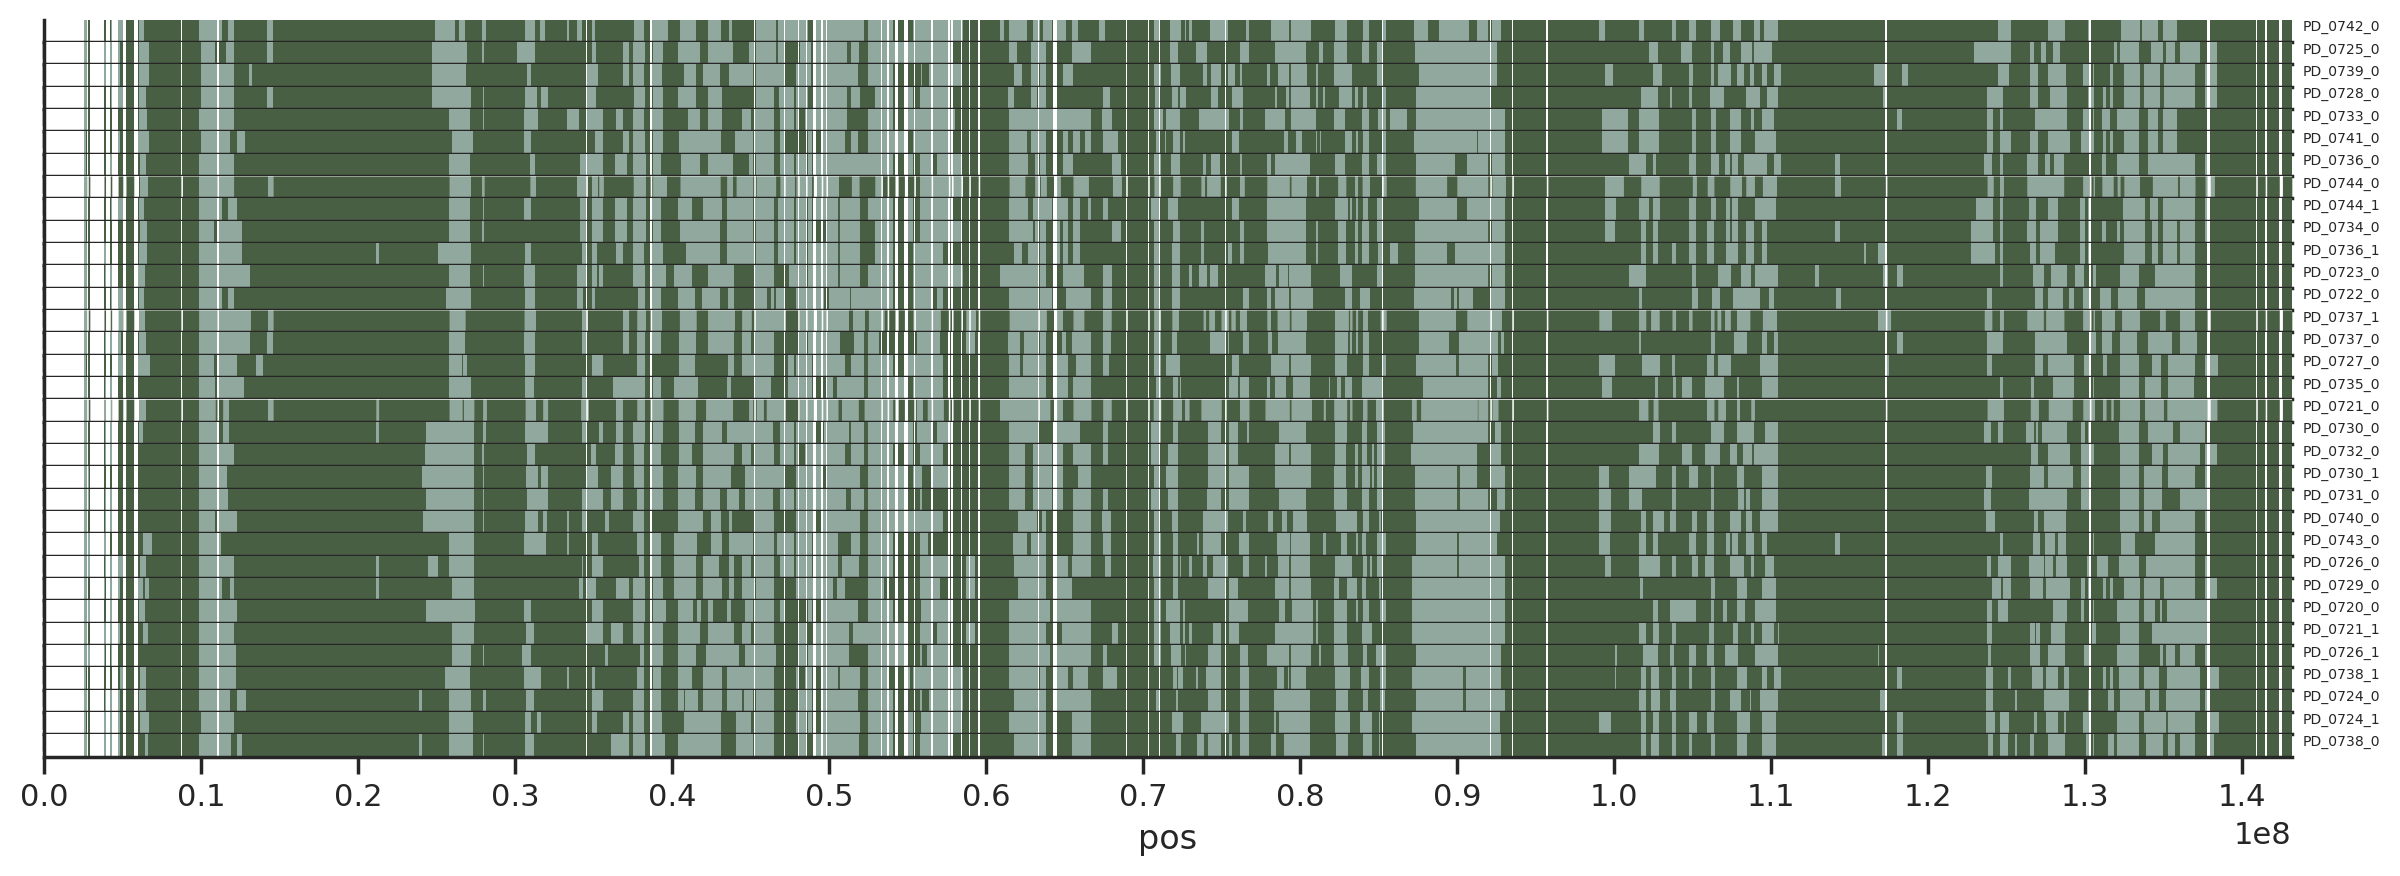

In [49]:
def stairs(df, start='pos', end='end_pos', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

plot_df = stairs(df_f).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.145, aspect=100,
                    row_order=haplo_ID_sorting, margin_titles=True, gridspec_kws={'hspace':0.0})

g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=olive_north,
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(haplo_ID_sorting, g.axes.flat):
    ax.set_xlim(plot_df.pos.min(), plot_df.pos.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(df.pos)+1, 10000000))
g.savefig("../figures/all_chrX_ethiopia_filt075_large.pdf")

In [19]:
df = df_eth.loc[df_eth.chrom == "chr8"]

df_l = []
for c in df.chrom.unique():
    print(c)
    l_df = df.loc[df.chrom == c].copy()
    if c == "female_chrX" or c == "all_chrX":
        c = "chrX"
    r_df = recomb_df.loc[(recomb_df.chromosome == c)]
    pos_mapping = dict(zip(r_df.position, r_df["Genetic_Map(cM)"]))
    l_df["start_cM"] = l_df.pos.map(pos_mapping)
    l_df["end"] = l_df.end_pos + 1
    l_df["end_cM"] = l_df.end.map(pos_mapping)
    call_df = c_r_g_df.loc[c_r_g_df.chrom == c]
    df_call_filt = []
    df_l.append(l_df)
df = pd.concat(df_l)
callable_df = call_df.loc[call_df.callable_frac > 0.75].reset_index()
c_s = callable_df.iloc[0].start
c_e, old_end = callable_df.iloc[0].start, 0
# Seems weird, but how makes it work correctly for identifying intervals in filters
r_s = callable_df.iloc[0].cM
sub_df_l, gap_df_l = [], []
for i, row in callable_df.iterrows():
    if c_e != row.start:# or i+1 == len(callable_df):
        sub_df = df.loc[(df.end_pos > c_s) & (df.pos < c_e)]
        sub_df.loc[sub_df.start_cM < r_s, "start_cM"] = r_s
        sub_df.loc[sub_df.end_cM > row.end_cM, "end_cM"] = row.end_cM
        sub_df.loc[sub_df.pos < c_s, "pos"] = c_s
        sub_df.loc[sub_df.end_pos > c_e, "end_pos"] = c_e
        sub_df_l.append(sub_df)
        # Add start/ends
        start_df = sub_df.loc[sub_df.pos == c_s].copy()
        start_df.end_pos, start_df.end_cM, start_df.north = c_s, r_s, 0
        end_df = sub_df.loc[sub_df.end_pos == c_e].copy()
        end_df.pos, end_df.cM, end_df.north = c_e, r_s, 0
        gap_df_l.append(start_df), gap_df_l.append(end_df)
        # update df_l with new slice of fragment_df
        c_s, c_e, r_s = row.start, row.end, row.cM
    else:
        c_e = row.end
df_filt = pd.concat(sub_df_l)
gap_df = pd.concat(gap_df_l)

chr8


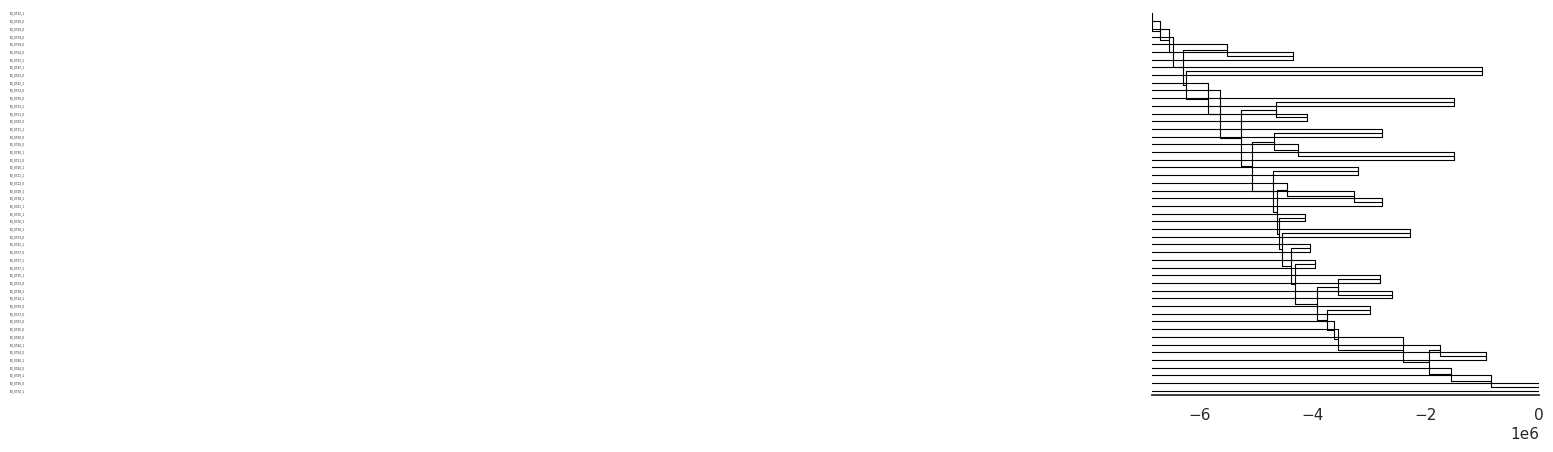

In [20]:
df['pop'] = df.haplo_ID
df['is_north'] = (df.north == 1).astype(int)
df['is_south'] = (df.north == -1).astype(int)
df = df.sort_values(['pop', 'chrom', 'start'])

df_f = pd.concat([df_filt, gap_df])
df_f['pop'] = df_f.haplo_ID
df_f['is_north'] = (df_f.north == 1).astype(int)
df_f['is_south'] = (df_f.north == -1).astype(int)
df_f['is_filtered'] = (df_f.north == 0).astype(int)
df_f = df_f.sort_values(['pop', 'chrom', 'pos', 'is_north', 'is_south'])

haplo_ID_list = list(df.haplo_ID.unique())

north_south_segment_lists = []
for sample_name in haplo_ID_list:
    north_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 1), ['pos', 'end_pos']].itertuples(index=False, name=None))
    south_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 0), ['pos', 'end_pos']].itertuples(index=False, name=None))
    north_south_segment_lists.append((north_tuples, south_tuples))
    
newick_str = tree_newick(haplo_ID_list, north_south_segment_lists, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

order_tree(tree, key=order_fun)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

leaf_info = plot_tree(tree, ax1, fontsize=2)
haplo_ID_sorting, x, y = zip(*leaf_info)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


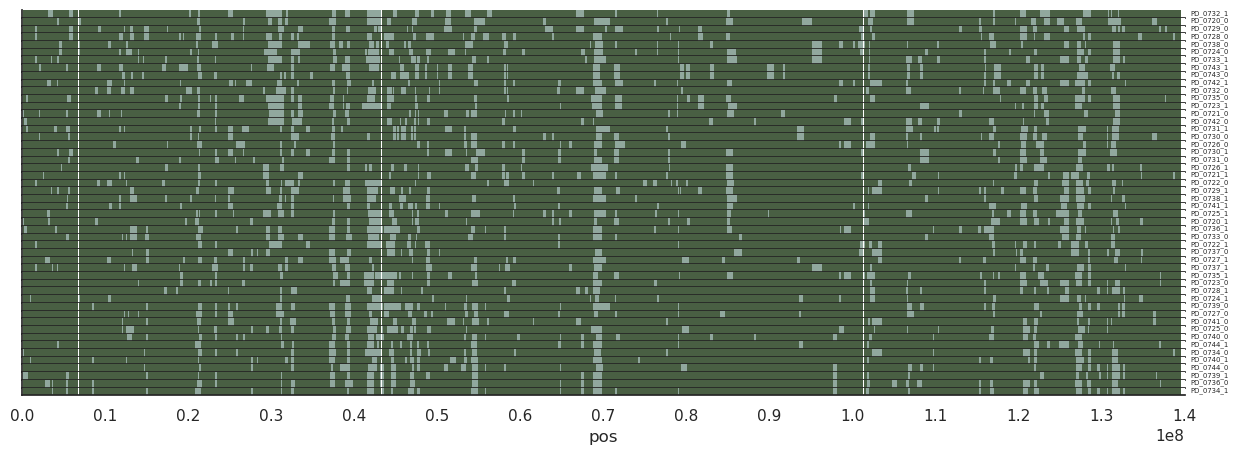

In [22]:
def stairs(df, start='pos', end='end_pos', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

plot_df = stairs(df_f).sort_values(['pop', 'chrom', 'pos', 'end_pos', 'is_filtered'])
g = sns.FacetGrid(plot_df, col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.1, aspect=150,
                    row_order=haplo_ID_sorting, margin_titles=True, gridspec_kws={'hspace':0.0})

g.map(plt.fill_between, 
    'pos', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'pos', 
    'is_south', 
    y2=0,
    color=olive_north,
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(haplo_ID_sorting, g.axes.flat):
    ax.set_xlim(plot_df.pos.min(), plot_df.end_pos.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(df.end_pos)+1, 10000000))
g.savefig("../figures/chr8_ethiopia_filt075.pdf")

In [38]:
meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(["PD_0494", "PD_0495", "PD_0496", "PD_0497", "PD_0498",
                                                      "PD_0499", "PD_0500", "PD_0501", "PD_0502", "PD_0503",
                                                      "PD_0504", "PD_0505", "PD_0506", "PD_0507", "PD_0508"])]
#PD_0509, PD_0637, PD_0641, PD_0642, PD_0649, PD_0650, PD_0651, PD_0652, PD_0653, PD_0654, PD_0658, PD_0659, PD_0662, PD_0674, PD_0675, PD_0676, PD_0677, PD_0678, PD_0679, PD_0680, PD_0681, PD_0682, PD_0683, PD_0684, PD_0685, PD_0686, PD_0687, PD_0688, PD_0689, PD_0690, PD_0691])]

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,callset_index,C_origin
78,PD_0494,18 / 24SNM5151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,78,"Anubis, Tanzania"
79,PD_0495,19 / 25SNF1161115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,79,"Anubis, Tanzania"
80,PD_0496,20 / 26SNM1181115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,80,"Anubis, Tanzania"
81,PD_0497,21 / 27SNM1191115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,81,"Anubis, Tanzania"
82,PD_0498,23 / 31SNM1201115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,82,"Anubis, Tanzania"
83,PD_0499,24 / 32SNF1201115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,83,"Anubis, Tanzania"
84,PD_0500,25 / 33SNF1201115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,84,"Anubis, Tanzania"
85,PD_0501,26 / 37SNF1221115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.742544,-1.996626,85,"Anubis, Tanzania"
86,PD_0502,38 / 10NCM8170516,Knauf/Chuma/Roos,Papio,anubis,"Ngorongoro, Tanzania",M,"Ngorongoro, Arusha, Northern Zone, Tanzania",35.585946,-2.676953,86,"Anubis, Tanzania"
87,PD_0503,44 / 14RUF5130716,Knauf/Chuma/Roos,Papio,cynocephalus,"Ruaha, Tanzania",F,"Ruaha, Ulanga, Morogoro, Coastal Zone, Tanzania",36.714814,-8.895386,87,"Cynocephalus, Central Tanzania"


Chromosome Transformation

In [24]:
df_l = []
for c in ["chr{}".format(x) for x in (range(1, 21))] + ["chrX"]:
    print(c)
    genetic_map = "/home/eriks/baboondiversity/data/PG_panu3_recombination_map/mikumi_pyrho_genetic_map_{}.txt"
    chr_recomb = pd.read_csv(genetic_map.format(c), sep=" ")
    df_l.append(chr_recomb)
recomb_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chrX


In [53]:
df_l = []
for c in length_df.chrom.unique():
    print(c)
    l_df = length_df.loc[length_df.chrom == c].copy()
    if c == "female_chrX" or c == "all_chrX":
        c = "chrX"
    r_df = recomb_df.loc[(recomb_df.chromosome == c)]
    pos_mapping = dict(zip(r_df.position, r_df["Genetic_Map(cM)"]))
    l_df["start_cM"] = l_df.pos.map(pos_mapping)
    l_df["end"] = l_df.end_pos + 1
    l_df["end_cM"] = l_df.end.map(pos_mapping)
    df_l.append(l_df)
r_admix_df = pd.concat(df_l)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
all_chrX
female_chrX


/scratch/25827618/ipykernel_3316238/2033779788.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pop'] = df.haplo_ID
/scratch/25827618/ipykernel_3316238/2033779788.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_north'] = (df.north == 1).astype(int)
/scratch/25827618/ipykernel_3316238/2033779788.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

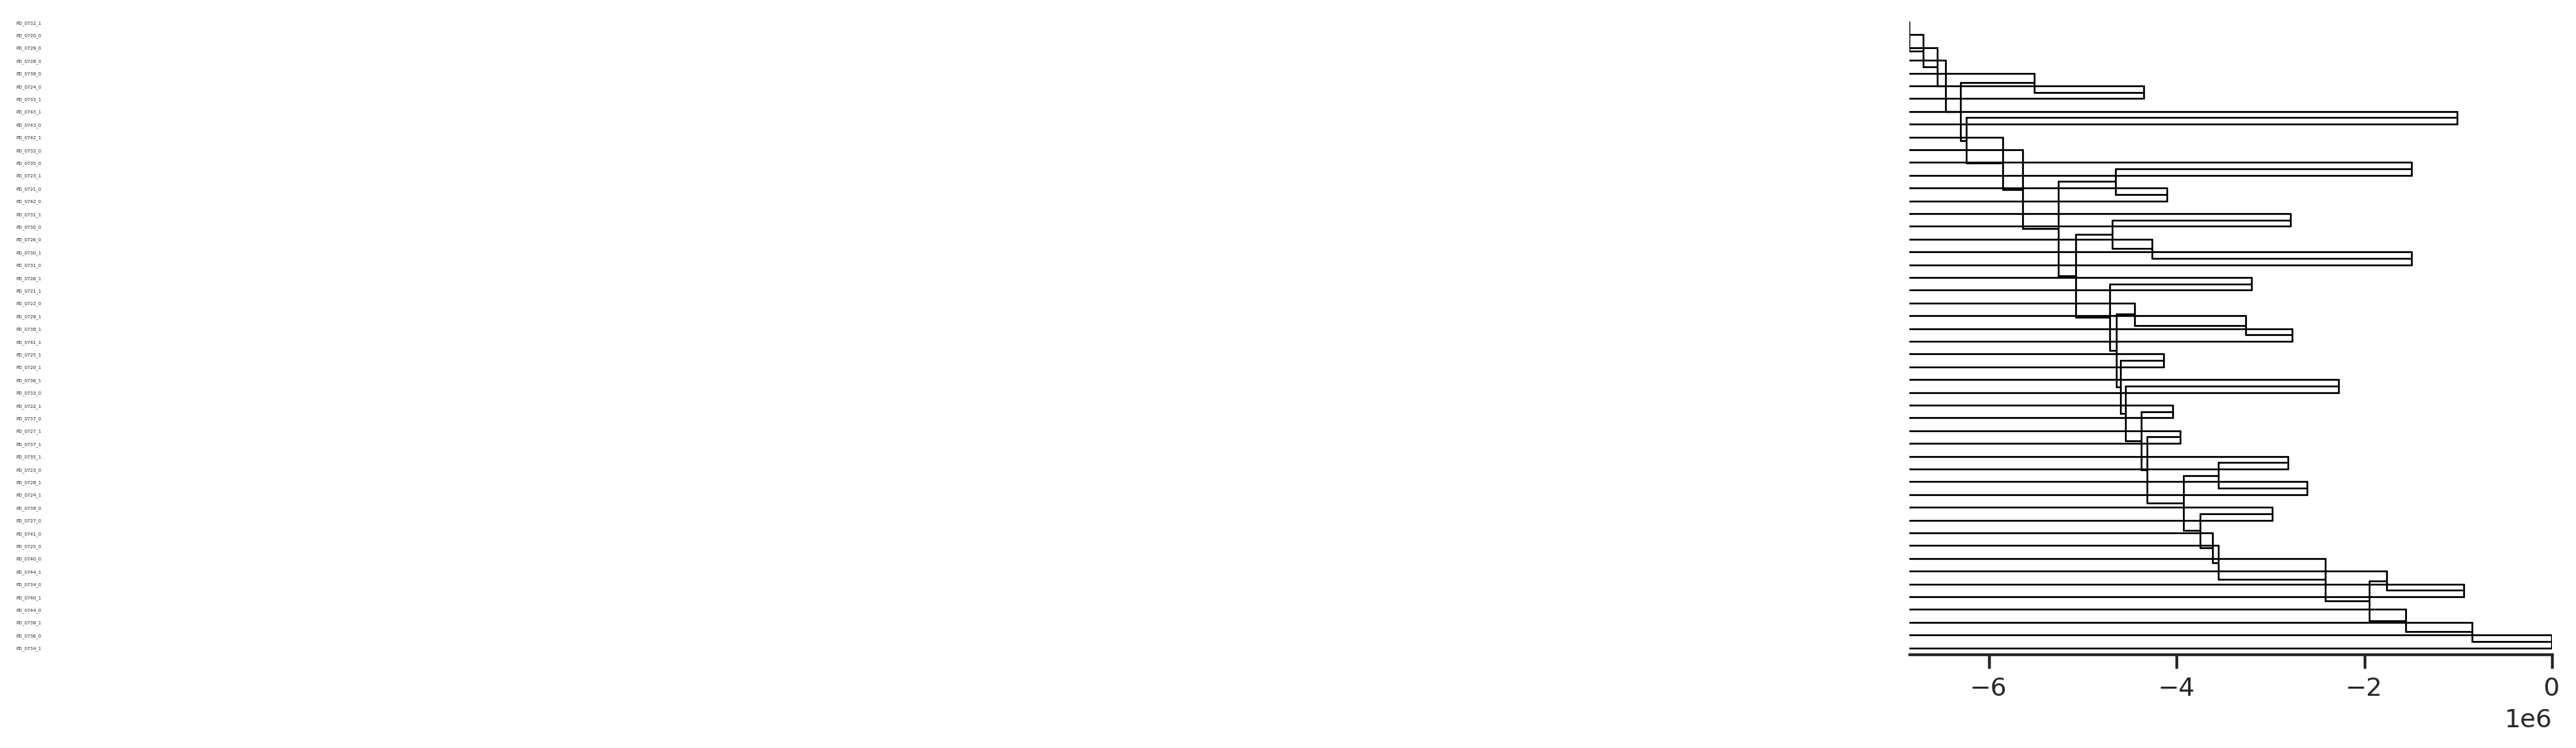

In [58]:
df_eth = r_admix_df.loc[r_admix_df.individual.isin(eth)]
df = df_eth.loc[df_eth.chrom == "chr8"]
df['pop'] = df.haplo_ID
df['is_north'] = (df.north == 1).astype(int)
df['is_south'] = (df.north == -1).astype(int)
df = df.sort_values(['pop', 'chrom', 'start'])

haplo_ID_list = list(df.haplo_ID.unique())

north_south_segment_lists = []
for sample_name in haplo_ID_list:
    north_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 1), ['pos', 'end_pos']].itertuples(index=False, name=None))
    south_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 0), ['pos', 'end_pos']].itertuples(index=False, name=None))
    north_south_segment_lists.append((north_tuples, south_tuples))
    
newick_str = tree_newick(haplo_ID_list, north_south_segment_lists, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

order_tree(tree, key=order_fun)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

leaf_info = plot_tree(tree, ax1, fontsize=2)
haplo_ID_sorting, x, y = zip(*leaf_info)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


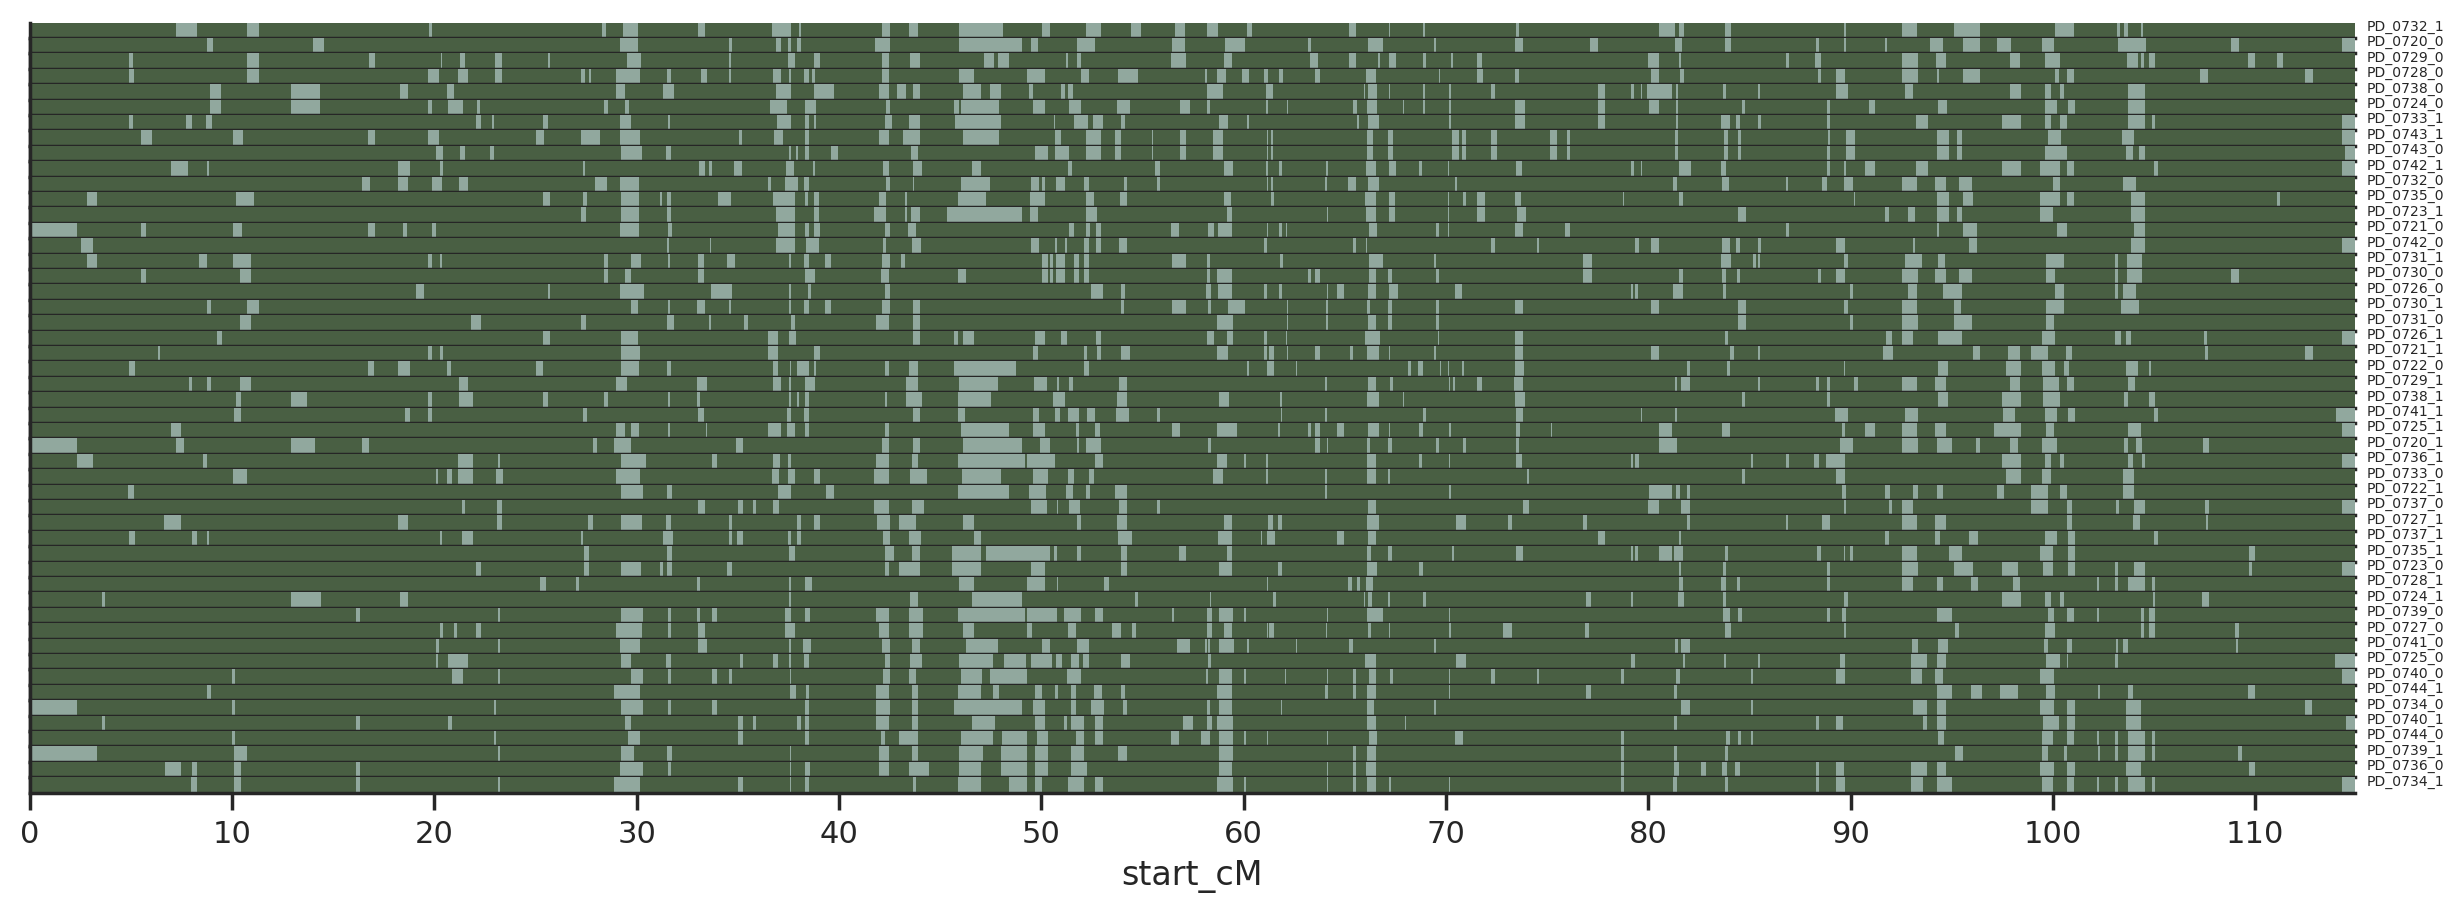

In [60]:
def stairs(df, start='pos', end='end_pos', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

g = sns.FacetGrid(stairs(df, start='start_cM', end='end_cM', pos='start_cM'), col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.1, aspect=150,
                    row_order=haplo_ID_sorting, margin_titles=True, gridspec_kws={'hspace':0.0})
plot_df = stairs(df, start='start_cM', end='end_cM', pos='start_cM')
g.map(plt.fill_between, 
    'start_cM', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'start_cM', 
    'is_south', 
    y2=0,
    color=olive_north,
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(haplo_ID_sorting, g.axes.flat):
    ax.set_xlim(plot_df.start_cM.min(), plot_df.start_cM.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(df.start_cM)+1, 10))

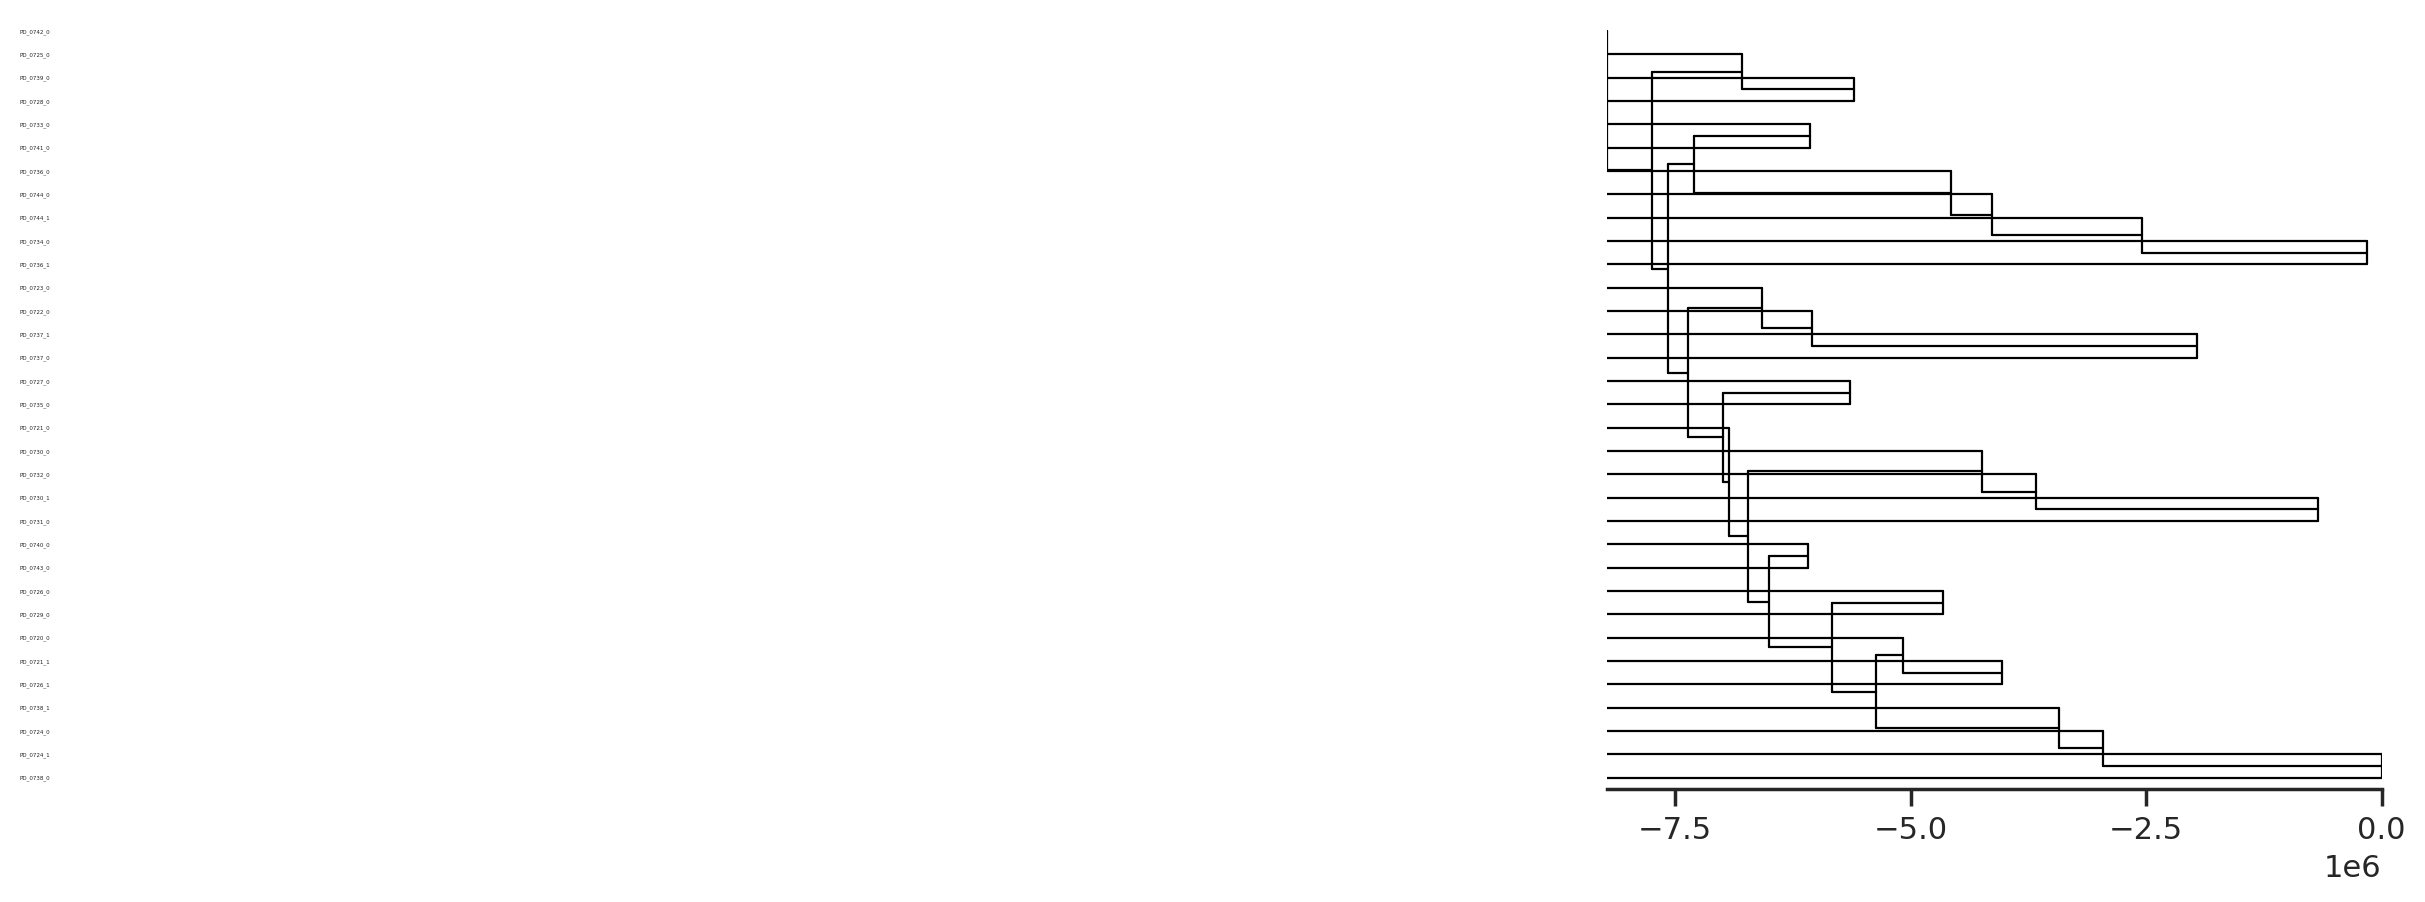

In [76]:
df_eth = r_admix_df.loc[r_admix_df.individual.isin(eth)]
df = df_eth.loc[df_eth.chrom == "all_chrX"]
df = df.loc[~(df.individual.isin(male_IDs) & (df.haplotype == "1"))]
df['pop'] = df.haplo_ID
df['is_north'] = (df.north == 1).astype(int)
df['is_south'] = (df.north == -1).astype(int)
df = df.sort_values(['pop', 'chrom', 'start'])

haplo_ID_list = list(df.haplo_ID.unique())

north_south_segment_lists = []
for sample_name in haplo_ID_list:
    north_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 1), ['pos', 'end_pos']].itertuples(index=False, name=None))
    south_tuples = list(df.loc[(df.haplo_ID == sample_name) & (df.is_north == 0), ['pos', 'end_pos']].itertuples(index=False, name=None))
    north_south_segment_lists.append((north_tuples, south_tuples))
    
newick_str = tree_newick(haplo_ID_list, north_south_segment_lists, dist_fun=proportion_same_ancestry)
tree = Tree(newick_str)

order_tree(tree, key=order_fun)

fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(5, 5))

leaf_info = plot_tree(tree, ax1, fontsize=2)
haplo_ID_sorting, x, y = zip(*leaf_info)

/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/eriks/miniconda3/envs/baboondiversity/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


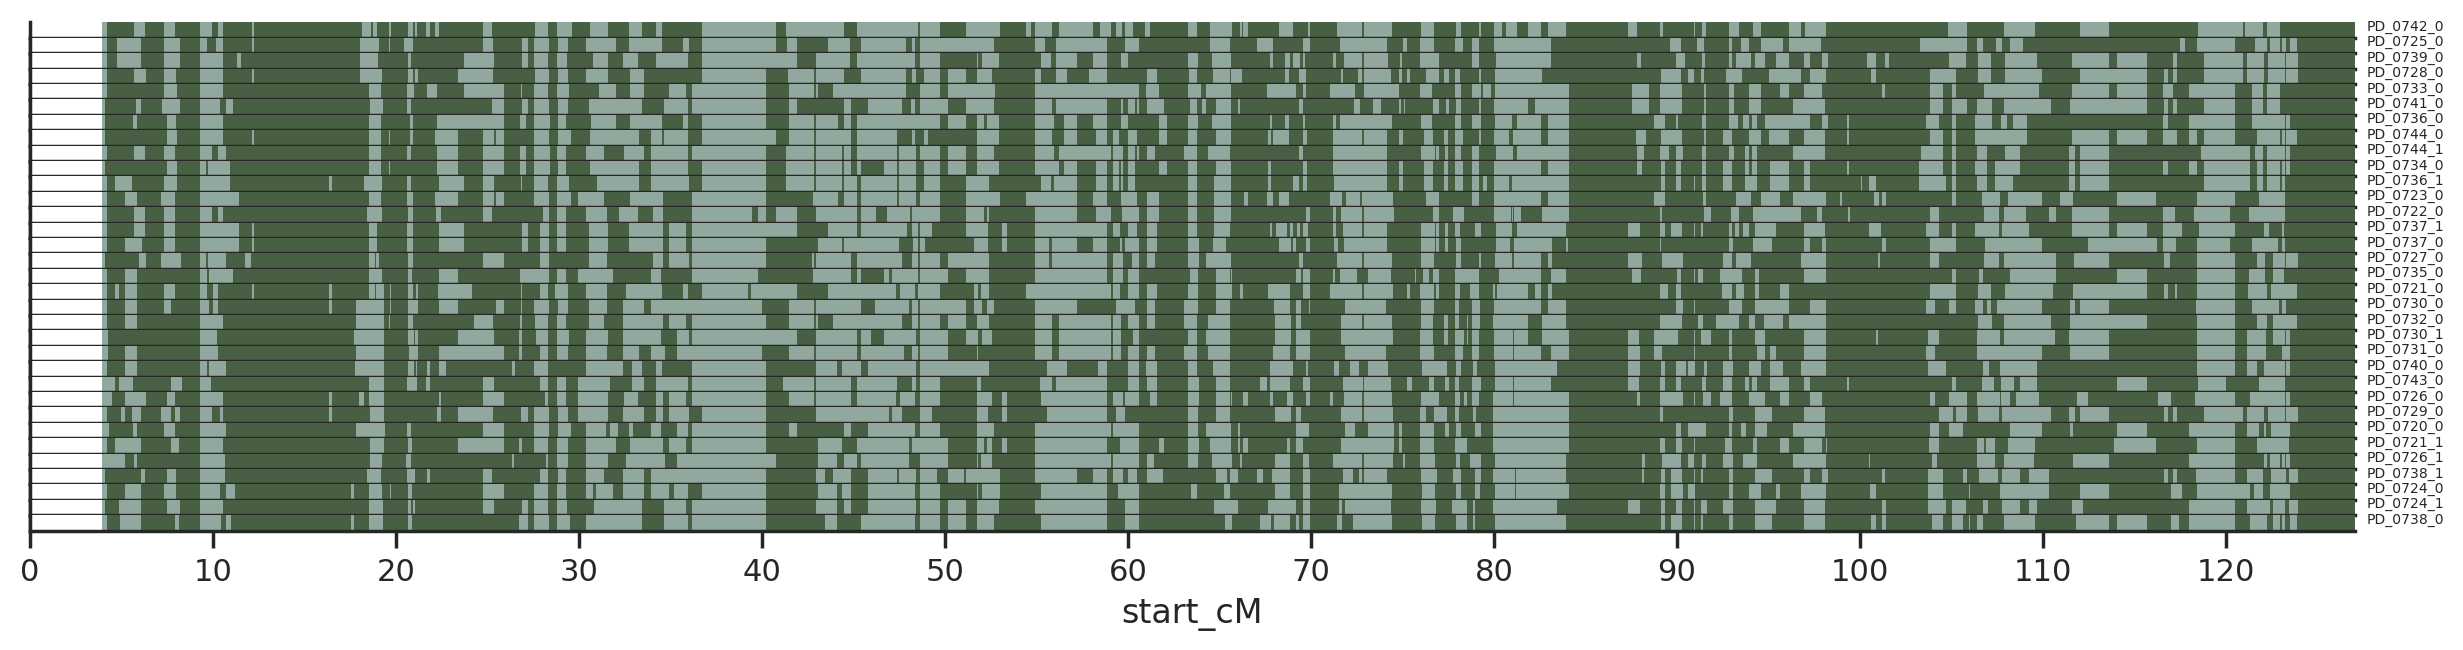

In [77]:
g = sns.FacetGrid(stairs(df, start='start_cM', end='end_cM', pos='start_cM'), col='chrom', row='haplo_ID', sharex=True, sharey=True, height=0.1, aspect=150,
                    row_order=haplo_ID_sorting, margin_titles=True, gridspec_kws={'hspace':0.0})
plot_df = stairs(df, start='start_cM', end='end_cM', pos='start_cM')
g.map(plt.fill_between, 
    'start_cM', 
    'is_north', 
    y2=0,
    color=hamadryas_north,
    linewidth=0,
    capstyle='butt')
g.map(plt.fill_between, 
    'start_cM', 
    'is_south', 
    y2=0,
    color=olive_north,
    linewidth=0,
    capstyle='butt')
g.set_titles(col_template="", row_template="")
g.set(yticklabels=[])  
g.set(ylabel=None)
g.tick_params(left=False)  # remove the ticks 
for label, ax in zip(haplo_ID_sorting, g.axes.flat):
    ax.set_xlim(plot_df.start_cM.min(), plot_df.start_cM.max())
    ax.set_ylim(0, 1)    
    ax.annotate(label, xy=(1.005 , 0.5), xycoords='axes fraction', ha='left', size=5)
    ax.set_xticks(np.arange(0, max(df.start_cM)+1, 10))